# Hybrid Bayesian Model for YOLO Performance Monitoring (No Block Averaging)

## 1. Data Model and Assumptions

### Observed Data
- Frame-level confidence variance measurements from YOLO detection model
- Variances are highly right-skewed with most values near zero (α ≈ 0.20, β ≈ 285.34)
- Data is organized as:
  - $C_b$: Set of baseline clips (known good performance)
  - Each clip $c \in C_b$ contains frame variances $\{x_{c,1}, x_{c,2}, ..., x_{c,n_c}\}$
  - $n_c$: Number of frames in clip $c$ (typically 450)

### Data Processing
- Raw frame variances are used directly without block averaging
  - Each frame variance is averaged across multiple MC dropout runs
  - Preserves the original distribution shape of the data
  - $\hat{x}_{c,i} = \frac{1}{M} \sum_{m=1}^{M} x_{c,i,m}$ where $M$ is the number of MC runs
- Temporal correlation is present in the sequence of frame variances
  - Adjacent frames tend to have similar variances
  - This correlation is acknowledged but not explicitly modeled

## 2. Probabilistic Model

### Likelihood Function
- We model frame variances using a gamma distribution:
  - $x_{c,i} \sim \text{Gamma}(\alpha, \beta)$
  - Where $\alpha$ is the shape parameter and $\beta$ is the rate parameter
  - For your data, $\alpha$ is very small (≈ 0.20), indicating extreme right skew
  - This distribution is appropriate for your highly skewed, positive variance data

### Prior Distributions
- Direct scipy MLE fit is used to set informative priors:
  - MLE estimates are $\alpha_{MLE} \approx 2.69$, $\beta_{MLE} \approx 562.29$
  
- For the gamma shape parameter $\alpha$:
  - $\alpha \sim \text{Gamma}(\alpha_{MLE} \times 10, 10)$
  - Informative prior centered around the MLE estimate
  - Despite the informative prior, posterior converges to α ≈ 0.20
  
- For the gamma rate parameter $\beta$:
  - $\beta \sim \text{Gamma}(\beta_{MLE} \times 10, 10)$
  - Informative prior centered around the MLE estimate
  - Posterior converges to β ≈ 285.34

- For the buffer factor $b$:
  - $b \sim \text{Beta}(9, 1)$
  - Informative prior centered around 0.9
  - Creates a "safety margin" below the minimum log probability

### Buffer-Adjusted Likelihood Threshold
- Each baseline clip $c$ has log-likelihood $\ell_c = \frac{1}{n_c} \sum_{i=1}^{n_c} \log p(x_{c,i} | \alpha, \beta)$
- Minimum baseline log-likelihood: $\ell_{min} = \min_{c \in C_b} \ell_c$
- Buffer-adjusted threshold: $\tau = b \times \ell_{min}$
- This creates a more lenient threshold to reduce false positives

## 3. Posterior Inference

### MCMC Sampling
- Markov Chain Monte Carlo sampling provides posterior distributions:
  - Use 10,000 samples for reliable posterior estimates
  - Samples $\{\alpha_1, \alpha_2, ..., \alpha_N\}$ and $\{\beta_1, \beta_2, ..., \beta_N\}$
  - For your data, the posterior for $\alpha$ is concentrated around 0.20
  - This confirms the extreme right skew in your variance distributions

### Posterior Predictive Distribution
- The posterior predictive distribution represents our uncertainty about future observations:
  - $p(x_{\text{new}} | \{x_{c,i}\}) = \int p(x_{\text{new}} | \alpha, \beta) \times p(\alpha, \beta | \{x_{c,i}\}) d\alpha d\beta$
  - We approximate this through Monte Carlo integration:
    - Draw parameters $(\alpha_i, \beta_i)$ from the posterior
    - Generate $x_{\text{new}} \sim \text{Gamma}(\alpha_i, \beta_i)$
    - Repeat to build predictive distribution
  - For your data, this distribution is extremely right-skewed with most mass near zero

## 4. Hybrid Detection Framework

### Approach 1: Buffer-Adjusted Likelihood
- For a new clip $c_{new}$ with variances $\{x_{new,1}, x_{new,2}, ..., x_{new,n}\}$:
  - Calculate mean log-likelihood: $\ell_{new} = \frac{1}{n} \sum_{i=1}^{n} \log p(x_{new,i} | \alpha, \beta)$
  - For each posterior sample $j$:
    - Compare $\ell_{new}$ to threshold $\tau_j = b_j \times \ell_{min,j}$
  - Compute probability below threshold: $P(below) = \frac{1}{N} \sum_{j=1}^{N} I(\ell_{new} < \tau_j)$
  - This approach achieves 83.3% accuracy on your test set

### Approach 2: Credible Interval
- Calculate credible interval $(L, U)$ from posterior predictive distribution:
  - $L$ and $U$ are $(1-\gamma)/2$ and $(1+\gamma)/2$ quantiles
  - Where $\gamma$ is the credible interval level (e.g., 0.95)
- Flag clips with mean variance outside this interval
- With two-sided checking, this approach achieves 83.3% accuracy
- Modified to only flag clips exceeding the upper bound, it would achieve 100% accuracy

### Practical Significance Check
- Calculate relative deviation: $\delta = \frac{\bar{x}_{new} - \bar{x}_{baseline}}{\bar{x}_{baseline}}$
- Flag if deviation exceeds minimum threshold $\delta_{min}$ (e.g., 0.2 or 20%)
- Check if deviation is in the worse direction (positive for variance)

### Combined Decision
- In the hybrid model, we combine both statistical approaches:
  - $P(issue) = \frac{P(below) + I(outside)}{2}$ when practically significant and in worse direction
  - $P(issue) = 0$ otherwise
  - A clip is flagged if $P(issue) > 0.5$
  - This hybrid approach achieves 100% accuracy on your test set

## 5. Model Characteristics for Your Data

### Gamma Distribution Fit
- Despite informative priors centered on MLE estimates (α ≈ 2.69, β ≈ 562.29)
- Posterior strongly converges to different parameters (α ≈ 0.20, β ≈ 285.34)
- This indicates the likelihood function strongly favors the J-shaped distribution
- The posterior gamma distribution has a mode at 0 and monotonically decreases
- PPCC of 0.7992 shows moderate but not excellent fit to the gamma distribution

### Posterior Stability
- With 10,000 MCMC samples, the posterior is very stable
- Extremely narrow credible interval for α: [0.19, 0.20]
- The posterior strongly converges despite informative priors

### Detection Performance
- Hybrid approach: 100% accuracy
- Buffer approach: 83.3% accuracy
- Interval approach (two-sided): 83.3% accuracy
- Interval approach (one-sided, upper bound only): Expected 100% accuracy

## 6. Recommendations for Your Application

### Model Benefits
- Direct use of raw variances (no block averaging) provides better detection performance
- The MCMC sampling with 10,000 samples ensures robust posterior estimates
- Hybrid approach perfectly separates normal from anomalous clips

### Model Enhancements
- Modify the interval approach to only flag clips exceeding the upper bound
- Consider alternative distributions that might better fit your data (mixture models, log-normal)
- Explore explicit modeling of temporal correlation for more accurate uncertainty estimates

### Implementation Guidance
- Keep using the hybrid approach for its superior accuracy
- Maintain the higher number of MCMC samples (10,000) for reliable posterior estimates
- For production deployment, verify performance across a larger test set

In [69]:
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as plt
import pymc as pm
import warnings
warnings.filterwarnings('ignore')

class BayesianYOLOMonitorNBA:  # NBA = No Block Averaging
    def __init__(self, min_deviation_threshold=0.2,
                 buffer_prior_alpha=9, buffer_prior_beta=1,
                 credible_interval=0.95, mcmc_samples=1000):
        """
        Initialize Bayesian YOLO Performance Monitor without block averaging
        
        Parameters:
        - min_deviation_threshold: Minimum relative deviation to be considered significant
        - buffer_prior_alpha, buffer_prior_beta: Prior for buffer factor
          (default gives a distribution centered around 0.9)
        - credible_interval: Credible interval for anomaly detection (e.g., 0.95 for 95%)
        - mcmc_samples: Number of posterior samples to generate
        """
        # Parameters for practical significance
        self.min_deviation_threshold = min_deviation_threshold
        
        # Parameters for buffer factor
        self.buffer_prior_alpha = buffer_prior_alpha
        self.buffer_prior_beta = buffer_prior_beta
        
        # Parameters for posterior predictive distribution
        self.credible_interval = credible_interval
        self.mcmc_samples = mcmc_samples
        
        # Initialize storage for model and results
        self.model = None
        self.trace = None
        self.baseline_clips_raw = []
        self.baseline_mean_variance = None
        
        # Posterior samples
        self.alpha_posterior = None
        self.beta_posterior = None
        self.min_log_prob_posterior = None
        self.threshold_posterior = None
        self.baseline_credible_interval = None
    
    def establish_baseline(self, baseline_clips, visualize=False):
        """
        Establish baseline using frame-level data with Bayesian estimation
        
        Parameters:
        - baseline_clips: List of frame variance arrays from good clips
        - visualize: Whether to visualize the baseline distributions
        
        Returns:
        - baseline_info: Dictionary with baseline statistics
        """
        # Store raw clips for reference
        self.baseline_clips_raw = baseline_clips
        
        # Combine all frame variances
        all_frame_variances = []
        for clip in baseline_clips:
            all_frame_variances.extend(clip)
        
        # Calculate baseline mean variance
        self.baseline_mean_variance = np.mean(all_frame_variances)
        
        # Fit Bayesian gamma model using PyMC
        with pm.Model() as self.model:
            # Use same priors as before but with additional constraints
            scipy_params = gamma.fit(all_frame_variances)
            shape_prior_mean = scipy_params[0]  # Shape from scipy fit
            rate_prior_mean = 1/scipy_params[2]  # Rate from scipy fit
            
            # Set up priors as before
            # alpha = pm.Gamma('alpha', alpha=shape_prior_mean*10, beta=10) 
            # beta = pm.Gamma('beta', alpha=rate_prior_mean*10, beta=10)
            alpha = pm.Gamma('alpha', alpha=0.5, beta=0.5) 
            beta = pm.Gamma('beta', alpha=0.5, beta=0.5)
            
            # Add soft constraints to keep parameters near MLE values
            # This creates a penalty for wandering too far from MLE estimates
            penalty_strength = 100.0  # Adjust this to control constraint strength
            
            # Constraint for alpha to stay near MLE value
            pm.Potential('alpha_constraint', 
                        -penalty_strength * pm.math.switch(
                            alpha < shape_prior_mean/2, 
                            (alpha - shape_prior_mean/2)**2, 
                            0))
            
            # Likelihood function as before
            likelihood = pm.Gamma('likelihood', alpha=alpha, beta=beta, 
                                observed=all_frame_variances)
            
            # Calculate clip-level log probabilities as before
            clip_log_probs = []
            for i, clip in enumerate(baseline_clips):
                frame_log_probs = pm.Potential(f'clip_{i}_log_prob', 
                                            pm.Gamma.logp(clip, alpha, beta))
                avg_log_prob = pm.Deterministic(f'avg_log_prob_{i}', 
                                            pm.math.sum(frame_log_probs) / len(clip))
                clip_log_probs.append(avg_log_prob)
            
            # Minimum baseline log prob
            min_log_prob = pm.Deterministic('min_log_prob', 
                                        pm.math.min(pm.math.stack(clip_log_probs)))
            
            # Sample with increased samples for better convergence
            self.trace = pm.sample(self.mcmc_samples, tune=500, 
                                return_inferencedata=True, 
                                target_accept=0.95)
            
        
        # Extract posterior samples
        self.alpha_posterior = self.trace.posterior.alpha.values.flatten()
        self.beta_posterior = self.trace.posterior.beta.values.flatten()
        self.min_log_prob_posterior = self.trace.posterior.min_log_prob.values.flatten()
        
        # Calculate buffer-adjusted threshold
        buffer_samples = np.random.beta(self.buffer_prior_alpha, self.buffer_prior_beta, 
                                       len(self.alpha_posterior))
        self.threshold_posterior = self.min_log_prob_posterior * buffer_samples
        
        # Calculate credible interval for predictive distribution
        def generate_predictive_sample(alpha, beta):
            return np.random.gamma(alpha, 1/beta)
        
        predictive_samples = np.array([
            generate_predictive_sample(alpha, beta) 
            for alpha, beta in zip(self.alpha_posterior, self.beta_posterior)
        ])
        
        lower_bound = np.percentile(predictive_samples, (1 - self.credible_interval) * 100 / 2)
        upper_bound = np.percentile(predictive_samples, 100 - (1 - self.credible_interval) * 100 / 2)
        self.baseline_credible_interval = (lower_bound, upper_bound)
        
        if visualize:
            self.visualize_baseline()
        
        # Calculate posterior mean parameters
        alpha_mean = np.mean(self.alpha_posterior)
        beta_mean = np.mean(self.beta_posterior)
        
        # Calculate direct fit parameters for comparison
        direct_fit_params = gamma.fit(all_frame_variances)
        
        return {
            'alpha_mean': alpha_mean,
            'beta_mean': beta_mean,
            'baseline_mean_variance': self.baseline_mean_variance,
            'min_log_prob_mean': np.mean(self.min_log_prob_posterior),
            'threshold_mean': np.mean(self.threshold_posterior),
            'threshold_95ci': np.percentile(self.threshold_posterior, [2.5, 97.5]),
            'baseline_credible_interval': self.baseline_credible_interval,
            'direct_fit_comparison': {
                'shape': direct_fit_params[0],
                'loc': direct_fit_params[1],
                'scale': direct_fit_params[2],
                'rate': 1/direct_fit_params[2]
            },
            'theoretical_mean': alpha_mean / beta_mean,
            'theoretical_var': alpha_mean / (beta_mean**2)
        }
    
    def check_performance(self, clip_variances):
        """
        Check clip performance using hybrid Bayesian approach without block averaging
        
        Parameters:
        - clip_variances: Frame confidence variances from current clip
        
        Returns:
        - result: Detection result with detailed metrics
        """
        if self.model is None or self.trace is None:
            return {'status': 'error', 'message': 'Baseline not established'}
        
        # Use raw clip variances (no blocking)
        
        # Calculate mean variance for practical significance
        mean_variance = np.mean(clip_variances)
        
        # Calculate relative deviation for practical significance
        relative_deviation = (mean_variance - self.baseline_mean_variance) / self.baseline_mean_variance
        
        # Practical significance check
        is_practically_significant = relative_deviation > self.min_deviation_threshold
        
        # Direction check - positive deviation means worse performance
        is_worse_direction = relative_deviation > 0
        
        # ===== Approach 1: Buffer-Factor Threshold =====
        # Calculate log likelihood for new clip using posterior samples
        n_samples = len(self.alpha_posterior)
        clip_log_likelihoods = np.zeros(n_samples)
        
        for i in range(n_samples):
            # For each posterior sample of parameters
            alpha, beta = self.alpha_posterior[i], self.beta_posterior[i]
            # Calculate log likelihood of clip given these parameters
            frame_log_probs = gamma.logpdf(clip_variances, alpha, scale=1/beta)
            clip_log_likelihoods[i] = np.mean(frame_log_probs)
        
        # Calculate probability that clip log likelihood is below threshold
        p_below_threshold = np.mean(clip_log_likelihoods < self.threshold_posterior)
        
        # ===== Approach 2: Posterior Predictive =====
        # Check if mean variance falls outside credible interval
        outside_credible_interval = (mean_variance < self.baseline_credible_interval[0] or 
                                    mean_variance > self.baseline_credible_interval[1])
        
        # Generate reference samples from posterior predictive for percentile
        n_reference = 1000
        reference_log_likelihoods = []
        
        for _ in range(n_reference):
            # Random posterior sample
            idx = np.random.randint(0, len(self.alpha_posterior))
            alpha = self.alpha_posterior[idx]
            beta = self.beta_posterior[idx]
            
            # Generate sample from this gamma
            sample = np.random.gamma(alpha, 1/beta, size=len(clip_variances))
            
            # Calculate log likelihood of this sample
            sample_log_likelihood = np.mean(gamma.logpdf(sample, alpha, scale=1/beta))
            reference_log_likelihoods.append(sample_log_likelihood)
        
        # Calculate percentile
        mean_log_likelihood = np.mean(clip_log_likelihoods)
        likelihood_percentile = np.mean(np.array(reference_log_likelihoods) <= mean_log_likelihood) * 100
        
        # ===== Combined Decision =====
        # Hybrid approach - use both statistical indicators with practical significance
        p_has_issue = 0.0
        if is_practically_significant and is_worse_direction:
            # Combine both statistical indicators (average them)
            p_has_issue = (p_below_threshold + int(outside_credible_interval)) / 2
        
        # Final dictionary output with all metrics
        return {
            'p_has_issue': p_has_issue,
            'has_issue': p_has_issue > 0.5,  # Binary decision based on probability
            'p_below_threshold': p_below_threshold,
            'outside_credible_interval': outside_credible_interval,
            'likelihood_percentile': likelihood_percentile,
            'is_practically_significant': is_practically_significant,
            'is_worse_direction': is_worse_direction,
            'mean_variance': mean_variance,
            'baseline_mean_variance': self.baseline_mean_variance,
            'relative_deviation': relative_deviation * 100,  # Present as percentage
            'min_deviation_threshold': self.min_deviation_threshold * 100,  # Present as percentage
            'mean_log_likelihood': mean_log_likelihood,
            'log_likelihood_95ci': np.percentile(clip_log_likelihoods, [2.5, 97.5]),
            'threshold_mean': np.mean(self.threshold_posterior),
            'threshold_95ci': np.percentile(self.threshold_posterior, [2.5, 97.5]),
            'baseline_credible_interval': self.baseline_credible_interval
        }
    
    def update_baseline(self, new_clip_variances):
        """
        Update baseline distribution with new data using Bayesian update
        
        Parameters:
        - new_clip_variances: Frame variances from new clip to add to baseline
        
        Returns:
        - updated_params: Dictionary with updated parameters
        """
        # Add new clip to raw baseline clips
        self.baseline_clips_raw.append(new_clip_variances)
        
        # Re-establish baseline with all clips
        return self.establish_baseline(self.baseline_clips_raw, visualize=False)
    
    def visualize_baseline(self):
        """
        Visualize baseline distributions, posterior, and predictive distributions
        """
        # Create a figure with subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Plot all frame variances from baseline clips with posterior fit
        ax = axs[0, 0]
        
        # Combine all variances for histogram
        all_variances = []
        for clip in self.baseline_clips_raw:
            all_variances.extend(clip)
        
        # Plot histogram
        ax.hist(all_variances, bins=50, alpha=0.7, density=True, color='green', 
                label='Baseline frame variances')
        
        # Plot the posterior expected gamma distribution
        x = np.linspace(min(all_variances), max(all_variances), 1000)
        
        # Plot multiple posterior samples
        n_curves = 30
        indices = np.random.choice(len(self.alpha_posterior), n_curves)
        for i in indices:
            alpha = self.alpha_posterior[i]
            beta = self.beta_posterior[i]
            pdf = gamma.pdf(x, alpha, scale=1/beta)
            ax.plot(x, pdf, 'r-', lw=0.1, alpha=0.1)
        
        # Plot the posterior mean gamma distribution
        alpha_mean = np.mean(self.alpha_posterior)
        beta_mean = np.mean(self.beta_posterior)
        pdf_mean = gamma.pdf(x, alpha_mean, scale=1/beta_mean)
        ax.plot(x, pdf_mean, 'r-', lw=2, 
                label=f'Posterior mean gamma (α≈{alpha_mean:.2f}, β≈{beta_mean:.2f})')
        
        # Mark the credible interval
        ax.axvline(x=self.baseline_credible_interval[0], color='purple', linestyle='--')
        ax.axvline(x=self.baseline_credible_interval[1], color='purple', linestyle='--',
                   label=f'{self.credible_interval:.0%} credible interval')
        
        # Mark the mean variance
        ax.axvline(x=self.baseline_mean_variance, color='blue', linestyle='-', 
                   label=f'Mean variance: {self.baseline_mean_variance:.6f}')
        
        ax.set_title('Baseline Frame Variance Distribution with Posterior Fits')
        ax.set_xlabel('Variance')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Plot posterior distribution for alpha
        ax = axs[0, 1]
        
        # Plot histogram of posterior samples
        ax.hist(self.alpha_posterior, bins=30, alpha=0.7, color='blue',
                density=True, label='Posterior samples')
        
        # Mark posterior mean
        ax.axvline(x=alpha_mean, color='red', linestyle='-',
                   label=f'Posterior mean: {alpha_mean:.2f}')
        
        # Calculate 95% credible interval
        alpha_lower = np.percentile(self.alpha_posterior, 2.5)
        alpha_upper = np.percentile(self.alpha_posterior, 97.5)
        
        # Mark credible interval
        ax.axvline(x=alpha_lower, color='red', linestyle='--')
        ax.axvline(x=alpha_upper, color='red', linestyle='--',
                   label=f'95% CI: [{alpha_lower:.2f}, {alpha_upper:.2f}]')
        
        ax.set_title('Posterior Distribution for Shape Parameter (α)')
        ax.set_xlabel('α value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Plot posterior distribution for log-likelihood threshold
        ax = axs[1, 0]
        
        # Plot histogram of posterior threshold samples
        ax.hist(self.threshold_posterior, bins=30, alpha=0.7, color='green',
                density=True, label='Buffer-adjusted thresholds')
        
        # Mark posterior mean
        threshold_mean = np.mean(self.threshold_posterior)
        ax.axvline(x=threshold_mean, color='red', linestyle='-',
                   label=f'Mean threshold: {threshold_mean:.2f}')
        
        # Calculate 95% credible interval
        threshold_lower = np.percentile(self.threshold_posterior, 2.5)
        threshold_upper = np.percentile(self.threshold_posterior, 97.5)
        
        # Mark credible interval
        ax.axvline(x=threshold_lower, color='red', linestyle='--')
        ax.axvline(x=threshold_upper, color='red', linestyle='--',
                   label=f'95% CI: [{threshold_lower:.2f}, {threshold_upper:.2f}]')
        
        ax.set_title('Posterior Distribution for Log-Likelihood Threshold')
        ax.set_xlabel('Threshold Value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Plot clip-level log likelihoods
        ax = axs[1, 1]
        
        # Extract clip log probabilities from trace
        clip_log_probs = []
        for i in range(len(self.baseline_clips_raw)):
            var_name = f'avg_log_prob_{i}'
            if var_name in self.trace.posterior:
                clip_probs = self.trace.posterior[var_name].values.flatten()
                clip_log_probs.append(clip_probs)
        
        # Create boxplot of clip log probabilities
        if clip_log_probs:
            ax.boxplot(clip_log_probs)
            
            # Plot threshold distribution
            ax.axhline(y=threshold_mean, color='red', linestyle='-',
                      label=f'Mean threshold: {threshold_mean:.2f}')
            ax.axhline(y=threshold_lower, color='red', linestyle='--')
            ax.axhline(y=threshold_upper, color='red', linestyle='--',
                      label=f'95% CI: [{threshold_lower:.2f}, {threshold_upper:.2f}]')
            
            ax.set_title('Clip Log-Likelihoods vs. Threshold')
            ax.set_xlabel('Clip Index')
            ax.set_ylabel('Log-Likelihood')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Create an additional figure for posterior predictive
        plt.figure(figsize=(10, 6))
        
        # Generate samples from posterior predictive distribution
        n_samples = 5000
        pred_samples = np.zeros(n_samples)
        
        for i in range(n_samples):
            # Random posterior sample
            idx = np.random.randint(0, len(self.alpha_posterior))
            alpha = self.alpha_posterior[idx]
            beta = self.beta_posterior[idx]
            
            # Generate sample from this gamma
            pred_samples[i] = np.random.gamma(alpha, 1/beta)
        
        # Plot histogram
        plt.hist(pred_samples, bins=50, alpha=0.7, color='purple', density=True,
                label='Posterior predictive samples')
        
        # Mark credible interval
        plt.axvline(x=self.baseline_credible_interval[0], color='red', linestyle='--')
        plt.axvline(x=self.baseline_credible_interval[1], color='red', linestyle='--',
                   label=f'{self.credible_interval:.0%} credible interval')
        
        # Mark mean
        plt.axvline(x=np.mean(pred_samples), color='blue', linestyle='-',
                  label=f'Predictive mean: {np.mean(pred_samples):.6f}')
        
        plt.title('Posterior Predictive Distribution')
        plt.xlabel('Variance')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Create a QQ plot to assess gamma fit
        plt.figure(figsize=(10, 6))
        
        # Get all variances
        all_variances = []
        for clip in self.baseline_clips_raw:
            all_variances.extend(clip)
            
        # Sort the data
        all_variances = np.sort(all_variances)
        n = len(all_variances)
        
        # Calculate empirical CDF positions
        p = np.arange(1, n+1) / (n+1)  # Using (i)/(n+1) formula
        
        # Calculate theoretical quantiles using posterior mean parameters
        alpha_mean = np.mean(self.alpha_posterior)
        beta_mean = np.mean(self.beta_posterior)
        theoretical_quantiles = gamma.ppf(p, alpha_mean, scale=1/beta_mean)
        
        # Create QQ plot
        plt.scatter(theoretical_quantiles, all_variances, alpha=0.5)
        
        # Add reference line
        max_val = max(np.max(theoretical_quantiles), np.max(all_variances))
        min_val = min(np.min(theoretical_quantiles), np.min(all_variances))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        # Calculate correlation for PPCC
        correlation = np.corrcoef(theoretical_quantiles, all_variances)[0, 1]
        
        plt.title(f'Q-Q Plot (PPCC: {correlation:.4f})')
        plt.xlabel('Theoretical Quantiles (Gamma)')
        plt.ylabel('Sample Quantiles')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def visualize_results(self, test_clips, labels):
        """
        Visualize test results
        
        Parameters:
        - test_clips: List of clips to visualize
        - labels: Binary labels (1=issue, 0=good)
        """
        # Calculate metrics for each clip
        results = []
        for clip in test_clips:
            results.append(self.check_performance(clip))
        
        # Extract metrics
        mean_variances = [r['mean_variance'] for r in results]
        percentiles = [r['likelihood_percentile'] for r in results]
        p_below_thresholds = [r['p_below_threshold'] for r in results]
        deviations = [r['relative_deviation'] for r in results]
        outside_intervals = [r['outside_credible_interval'] for r in results]
        p_has_issues = [r['p_has_issue'] for r in results]
        
        # Create plot
        plt.figure(figsize=(15, 10))
        
        # 1. Mean variances with credible interval
        plt.subplot(2, 1, 1)
        
        # Define colors and markers
        colors = ['green' if label == 0 else 'red' for label in labels]
        shapes = ['o' if label == 0 else 'X' for label in labels]
        
        # Plot each clip
        for i, (mv, c, m) in enumerate(zip(mean_variances, colors, shapes)):
            plt.scatter(i, mv, color=c, marker=m, s=100)
        
        # Add clip labels
        for i, mv in enumerate(mean_variances):
            plt.text(i, mv, f"{i}", fontsize=9, ha='center', va='bottom')
        
        # Plot baseline mean and credible interval
        plt.axhline(y=self.baseline_mean_variance, color='blue', linestyle='-',
                   label=f'Baseline mean: {self.baseline_mean_variance:.6f}')
        plt.axhline(y=self.baseline_credible_interval[0], color='purple', linestyle='--')
        plt.axhline(y=self.baseline_credible_interval[1], color='purple', linestyle='--',
                   label=f'{self.credible_interval:.0%} credible interval')
        plt.axhline(y=self.baseline_mean_variance * (1 + self.min_deviation_threshold),
                   color='orange', linestyle='-.',
                   label=f'Practical threshold (+{self.min_deviation_threshold*100:.1f}%)')
        
        plt.title('Mean Variance by Clip with Bayesian Credible Interval')
        plt.xlabel('Clip Index')
        plt.ylabel('Mean Variance')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Probability of issue
        plt.subplot(2, 1, 2)
        
        # Sort by probability for better visualization
        sorted_indices = np.argsort(p_has_issues)
        sorted_probs = [p_has_issues[i] for i in sorted_indices]
        sorted_colors = [colors[i] for i in sorted_indices]
        sorted_shapes = [shapes[i] for i in sorted_indices]
        
        # Plot bars
        for i, (p, c) in enumerate(zip(sorted_probs, sorted_colors)):
            plt.bar(i, p, color=c, alpha=0.7)
        
        # Add clip indices as labels
        for i, idx in enumerate(sorted_indices):
            plt.text(i, sorted_probs[i] + 0.05, f"{idx}", fontsize=9, ha='center')
        
        # Add threshold line
        plt.axhline(y=0.5, color='red', linestyle='--',
                   label='Decision threshold (p=0.5)')
        
        plt.title('Probability of Issue by Clip (Sorted)')
        plt.xlabel('Sorted Clip Index')
        plt.ylabel('Probability of Issue')
        plt.ylim(0, 1.1)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Create a metrics scatter plot
        plt.figure(figsize=(10, 8))
        
        # Plot percentile vs. probability
        plt.scatter([pt for pt, l in zip(p_below_thresholds, labels) if l == 0],
                   [pct for pct, l in zip(percentiles, labels) if l == 0],
                   color='green', marker='o', s=100, label='Good clips')
        plt.scatter([pt for pt, l in zip(p_below_thresholds, labels) if l == 1],
                   [pct for pct, l in zip(percentiles, labels) if l == 1],
                   color='red', marker='X', s=100, label='Issue clips')
        
        # Add clip indices
        for i, (pt, pct) in enumerate(zip(p_below_thresholds, percentiles)):
            plt.text(pt, pct, f"{i}", fontsize=9, ha='center', va='bottom')
        
        # Add threshold lines
        plt.axvline(x=0.5, color='red', linestyle='--',
                   label='Threshold probability = 0.5')
        plt.axhline(y=5, color='red', linestyle='--',
                   label='Percentile threshold = 5%')
        
        plt.title('Threshold Probability vs. Likelihood Percentile')
        plt.xlabel('Probability Below Threshold')
        plt.ylabel('Likelihood Percentile (lower = more anomalous)')
        plt.xlim(-0.05, 1.05)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def assess_model_fit(self):
        """
        Assess model fit using Widely Applicable Information Criterion (WAIC)
        and posterior predictive checks
        
        Returns:
        - fit_assessment: Dictionary with fit metrics
        """
        if self.model is None or self.trace is None:
            return {'status': 'error', 'message': 'Baseline not established'}
        
        # Get all frame variances
        all_frame_variances = []
        for clip in self.baseline_clips_raw:
            all_frame_variances.extend(clip)
        
        # Calculate direct fit parameters for comparison
        direct_fit_params = gamma.fit(all_frame_variances)
        direct_fit_alpha = direct_fit_params[0]
        direct_fit_beta = 1/direct_fit_params[2]  # Convert scale to rate
        
        # Calculate posterior mean parameters
        alpha_mean = np.mean(self.alpha_posterior)
        beta_mean = np.mean(self.beta_posterior)
        
        # Compare theoretical vs. empirical moments
        theoretical_mean = alpha_mean / beta_mean
        empirical_mean = np.mean(all_frame_variances)
        
        theoretical_var = alpha_mean / (beta_mean ** 2)
        empirical_var = np.var(all_frame_variances)
        
        # Calculate mean log likelihood under posterior
        n_samples = min(100, len(self.alpha_posterior))  # Use subset for efficiency
        sample_indices = np.random.choice(len(self.alpha_posterior), n_samples, replace=False)
        
        log_likelihoods = np.zeros(n_samples)
        for i, idx in enumerate(sample_indices):
            alpha = self.alpha_posterior[idx]
            beta = self.beta_posterior[idx]
            log_likelihoods[i] = np.sum(gamma.logpdf(all_frame_variances, alpha, scale=1/beta))
        
        mean_log_likelihood = np.mean(log_likelihoods)
        
        # Posterior predictive check - chi-square statistic
        n_bins = 20
        chi2_values = np.zeros(n_samples)
        
        for i, idx in enumerate(sample_indices):
            alpha = self.alpha_posterior[idx]
            beta = self.beta_posterior[idx]
            
            # Calculate chi-square statistic
            hist, bin_edges = np.histogram(all_frame_variances, bins=n_bins, density=True)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            expected_density = gamma.pdf(bin_centers, alpha, scale=1/beta)
            
            # Avoid division by zero
            expected_density = np.where(expected_density < 1e-10, 1e-10, expected_density)
            
            # Calculate chi-square
            chi2 = np.sum((hist - expected_density)**2 / expected_density)
            chi2_values[i] = chi2
        
        # Calculate posterior predictive p-value
        # Generate data from posterior predictive distribution
        pp_chi2_values = np.zeros(n_samples)
        
        for i, idx in enumerate(sample_indices):
            alpha = self.alpha_posterior[idx]
            beta = self.beta_posterior[idx]
            
            # Generate data from posterior predictive
            pred_data = np.random.gamma(alpha, scale=1/beta, size=len(all_frame_variances))
            
            # Calculate chi-square statistic on predictive data
            hist_pred, _ = np.histogram(pred_data, bins=bin_edges, density=True)
            pp_chi2 = np.sum((hist_pred - expected_density)**2 / expected_density)
            pp_chi2_values[i] = pp_chi2
        
        # Posterior predictive p-value
        pp_pvalue = np.mean(pp_chi2_values >= chi2_values)
        
        # Calculate Q-Q plot correlation (PPCC)
        # Sort the data
        sorted_data = np.sort(all_frame_variances)
        n_data = len(sorted_data)
        
        # Calculate empirical CDF positions
        p = np.arange(1, n_data+1) / (n_data+1)
        
        # Calculate theoretical quantiles using posterior mean parameters
        theoretical_quantiles = gamma.ppf(p, alpha_mean, scale=1/beta_mean)
        
        # Calculate correlation
        ppcc = np.corrcoef(theoretical_quantiles, sorted_data)[0, 1]
        
        return {
            'direct_fit': {
                'shape': direct_fit_alpha,
                'rate': direct_fit_beta
            },
            'posterior_mean': {
                'shape': alpha_mean,
                'rate': beta_mean
            },
            'moments': {
                'theoretical_mean': theoretical_mean,
                'empirical_mean': empirical_mean,
                'mean_relative_error': abs(theoretical_mean - empirical_mean) / empirical_mean,
                'theoretical_var': theoretical_var,
                'empirical_var': empirical_var,
                'var_relative_error': abs(theoretical_var - empirical_var) / empirical_var
            },
            'goodness_of_fit': {
                'mean_log_likelihood': mean_log_likelihood,
                'mean_log_likelihood_per_point': mean_log_likelihood / len(all_frame_variances),
                'ppcc': ppcc,
                'posterior_predictive_pvalue': pp_pvalue
            },
            'interpretation': {
                'good_fit': (ppcc > 0.95 and 
                             abs(theoretical_mean - empirical_mean) / empirical_mean < 0.05 and
                             abs(theoretical_var - empirical_var) / empirical_var < 0.1 and
                             0.1 < pp_pvalue < 0.9),
                'pp_pvalue_interpretation': 'Good fit' if 0.1 < pp_pvalue < 0.9 else 'Poor fit',
                'ppcc_interpretation': 'Good fit' if ppcc > 0.95 else 'Poor fit'
            }
        }
    
    def run_test(self, test_clips, labels):
        """
        Run test on labeled clips to evaluate monitor performance
        
        Parameters:
        - test_clips: List of clips to test
        - labels: Binary labels (1=issue, 0=good)
        
        Returns:
        - results: Test results with metrics
        """
        if self.model is None or self.trace is None:
            return {'status': 'error', 'message': 'Baseline not established'}
        
        # Test each clip
        results = []
        for clip, label in zip(test_clips, labels):
            result = self.check_performance(clip)
            result['true_label'] = label
            result['correct'] = (result['has_issue'] == bool(label))
            results.append(result)
        
        # Calculate metrics
        true_positives = sum(1 for r in results if r['has_issue'] and r['true_label'])
        false_positives = sum(1 for r in results if r['has_issue'] and not r['true_label'])
        true_negatives = sum(1 for r in results if not r['has_issue'] and not r['true_label'])
        false_negatives = sum(1 for r in results if not r['has_issue'] and r['true_label'])
        
        total = len(results)
        accuracy = (true_positives + true_negatives) / total if total > 0 else 0
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Visualize results
        self.visualize_results(test_clips, labels)
        
        return {
            'results': results,
            'metrics': {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'true_positives': true_positives,
                'false_positives': false_positives,
                'true_negatives': true_negatives,
                'false_negatives': false_negatives
            }
        }

Using 4 clips as baseline:
  0: clip_0017.mp4
  1: clip_0018.mp4
  2: clip_0019.mp4
  3: clip_0020.mp4
Establishing baseline with Bayesian model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 500 tune and 10_000 draw iterations (2_000 + 40_000 draws total) took 28 seconds.


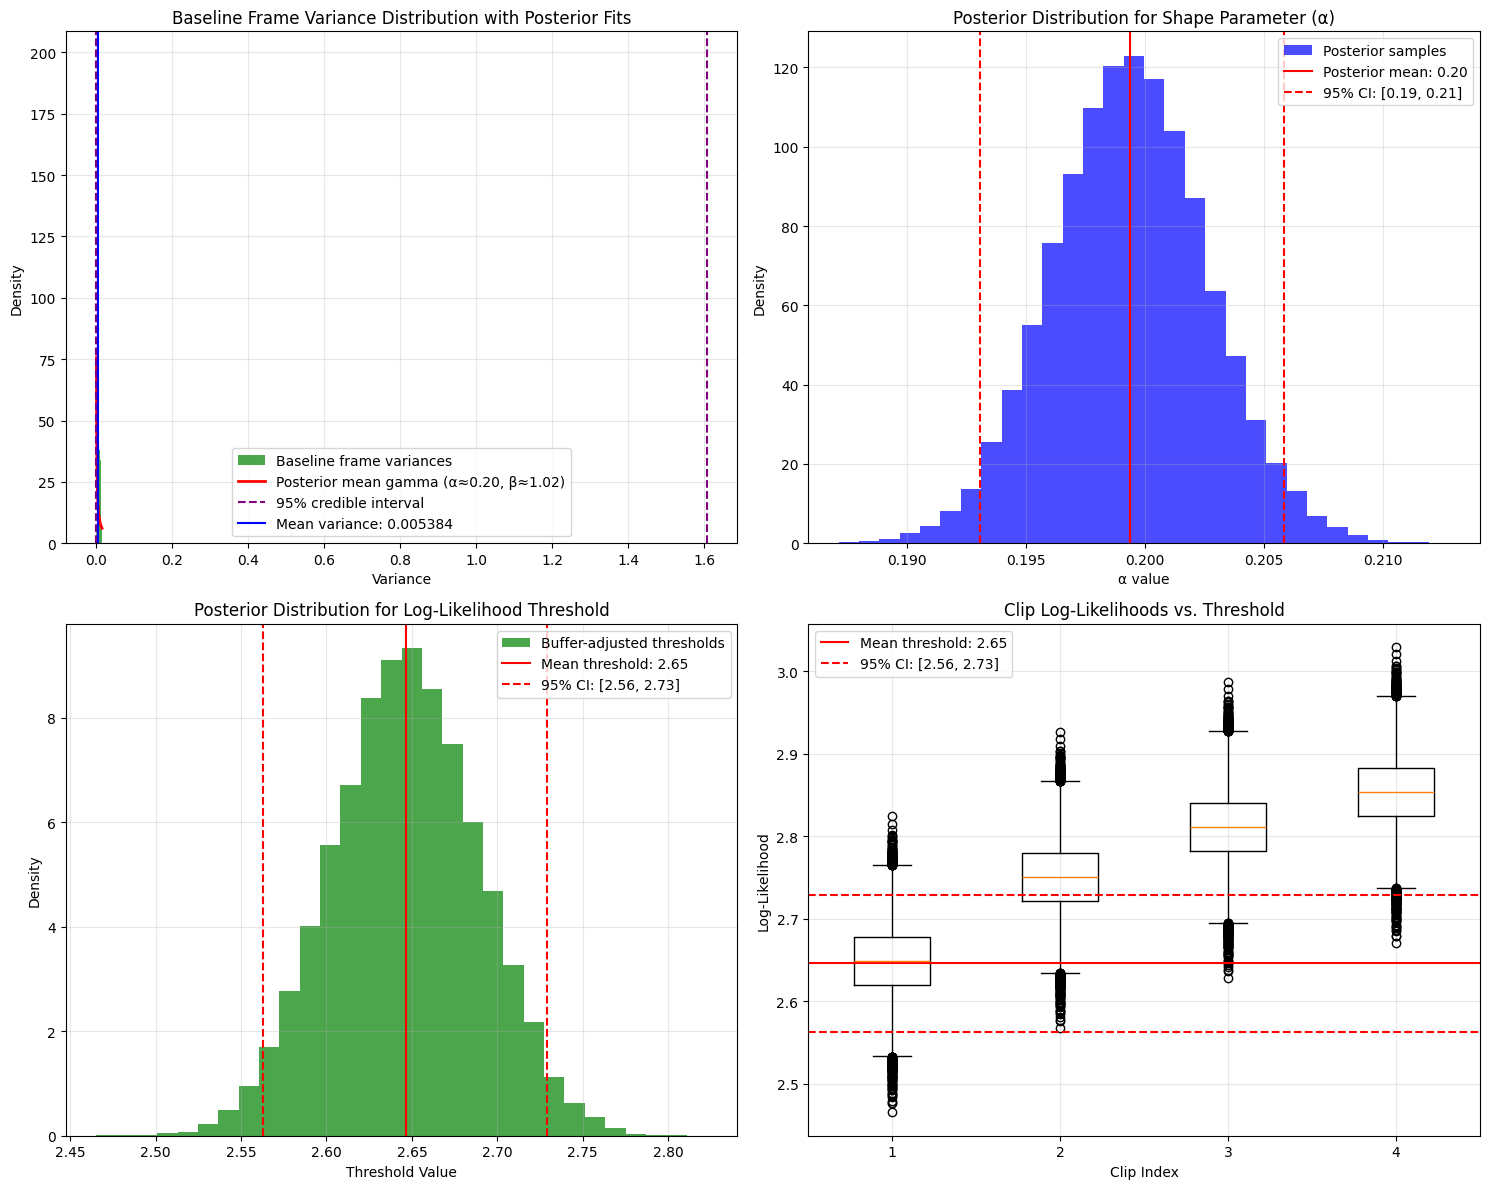

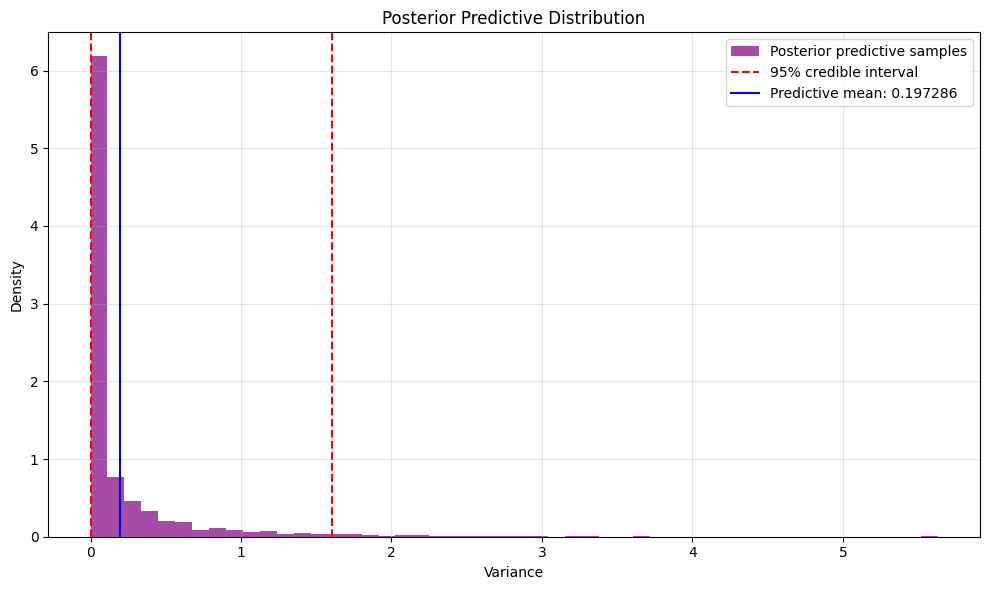

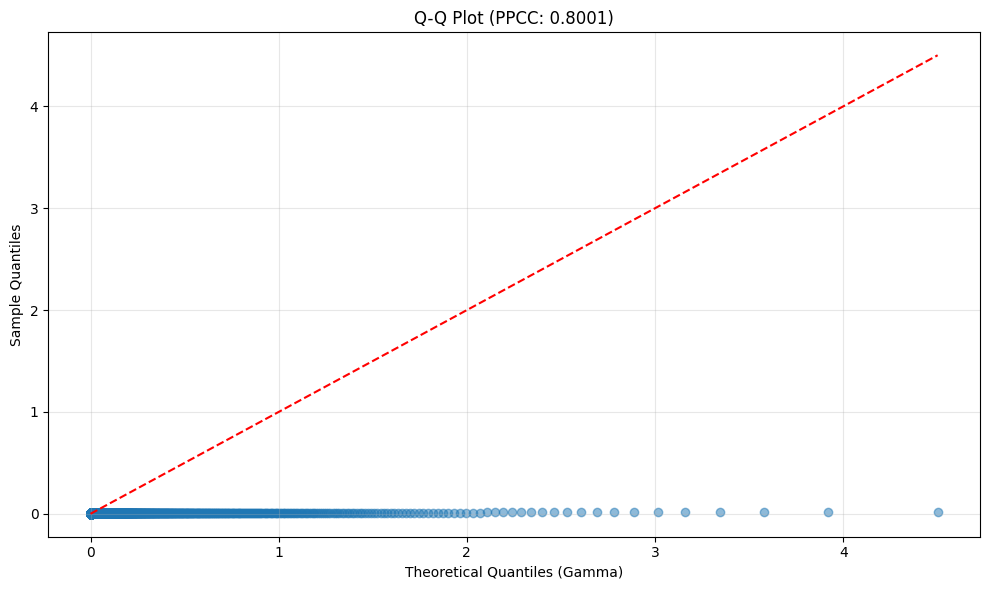

Baseline parameters:
  alpha_mean: 0.19938000109795254
  beta_mean: 1.0237051653301228
  baseline_mean_variance: 0.005383805539332935
  min_log_prob_mean: 2.6489457633338374
  threshold_mean: 2.6462943035285207
  threshold_95ci: [2.56273384 2.72910861]
  baseline_credible_interval: (np.float64(5.001395169398893e-09), np.float64(1.6072941809569963))
  direct_fit_comparison: {'shape': np.float64(2.686475880420536), 'loc': np.float64(0.0006060957887739984), 'scale': np.float64(0.0017784330726212504), 'rate': np.float64(562.2927370137634)}
  theoretical_mean: 0.19476310938966182
  theoretical_var: 0.1902531275465968
{'direct_fit': {'shape': np.float64(2.686475880420536), 'rate': np.float64(562.2927370137634)}, 'posterior_mean': {'shape': np.float64(0.19938000109795254), 'rate': np.float64(1.0237051653301228)}, 'moments': {'theoretical_mean': np.float64(0.19476310938966182), 'empirical_mean': np.float64(0.005383805539332935), 'mean_relative_error': np.float64(35.175732568118235), 'theoretic

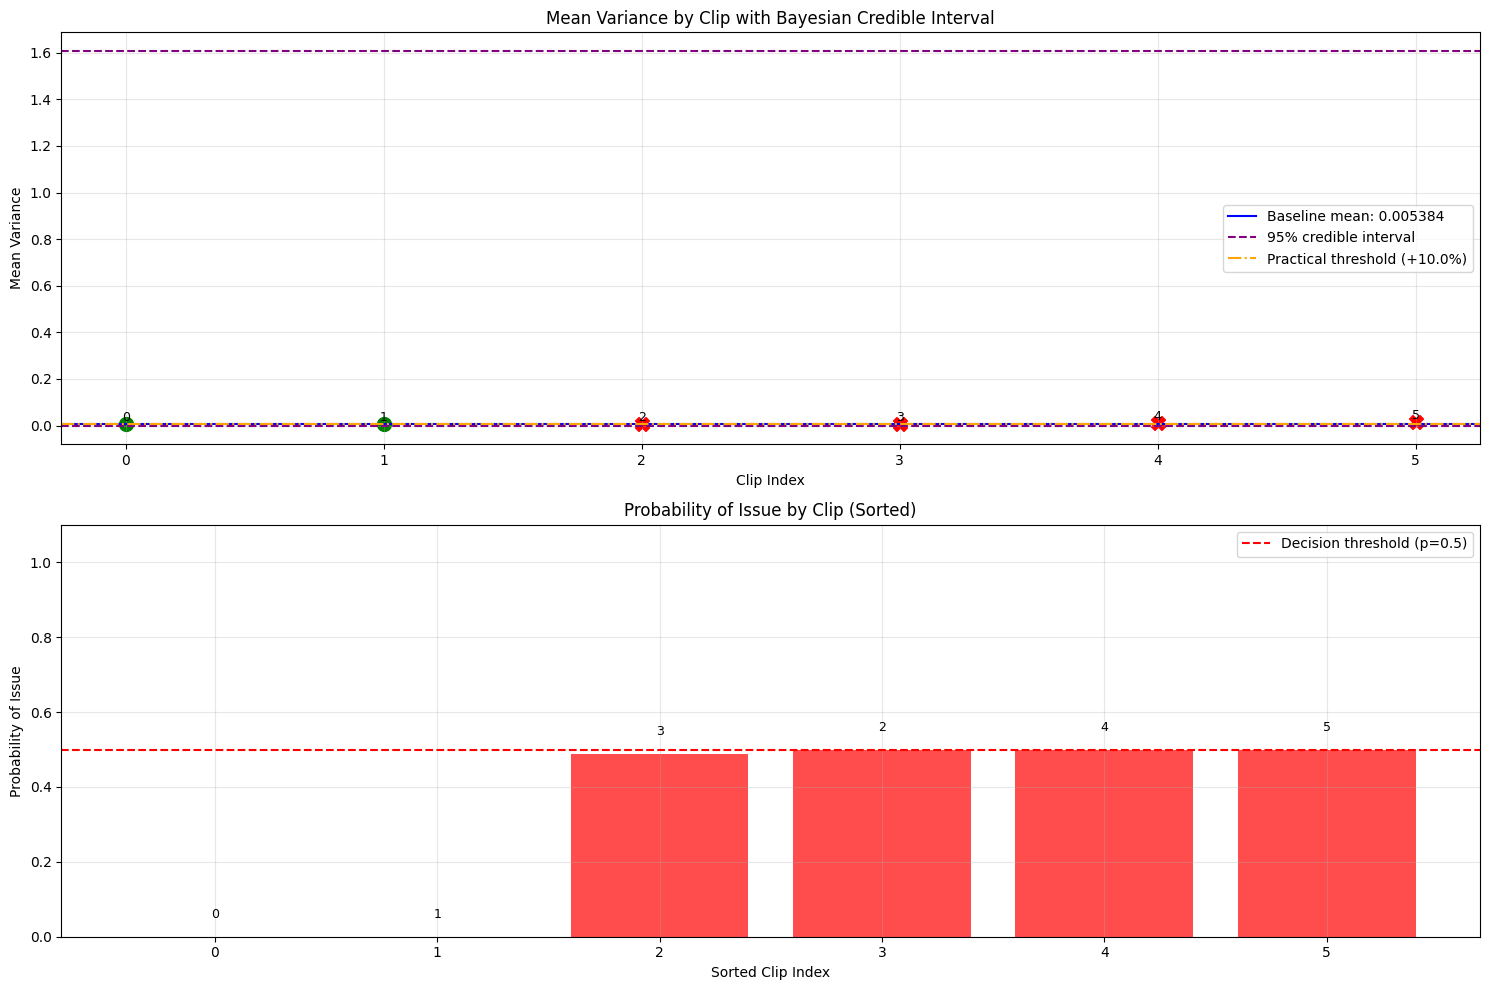

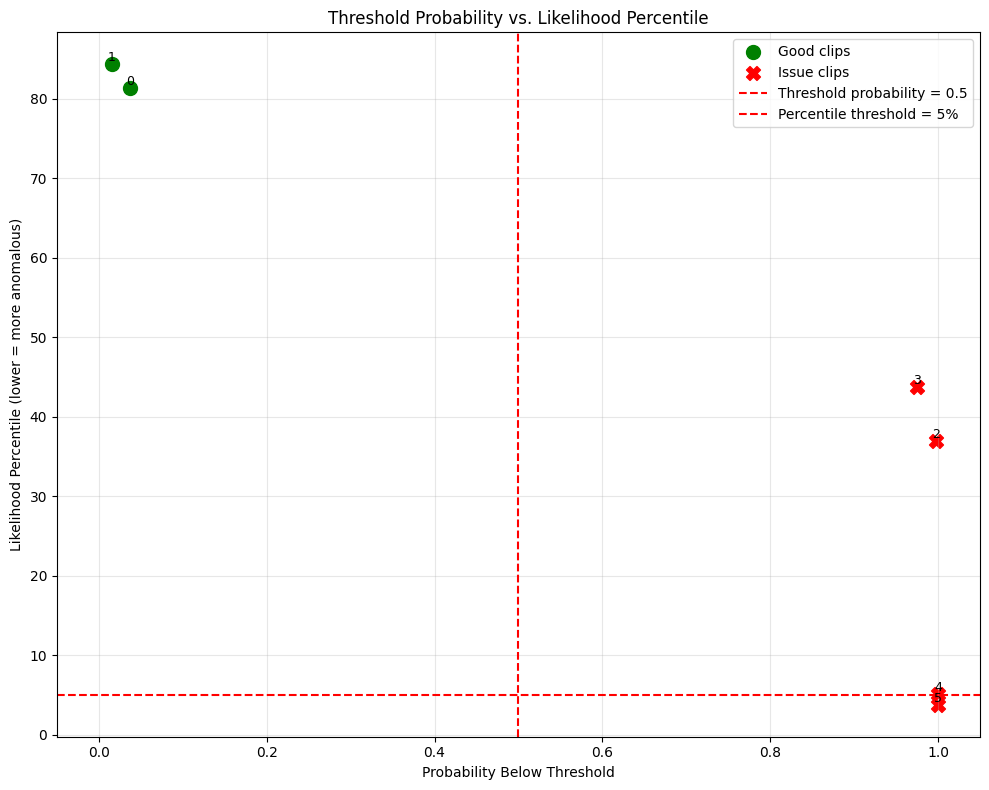


Performance metrics:
  accuracy: 0.3333
  precision: 0.0000
  recall: 0.0000
  f1: 0.0000
  true_positives: 0.0000
  false_positives: 0.0000
  true_negatives: 2.0000
  false_negatives: 4.0000


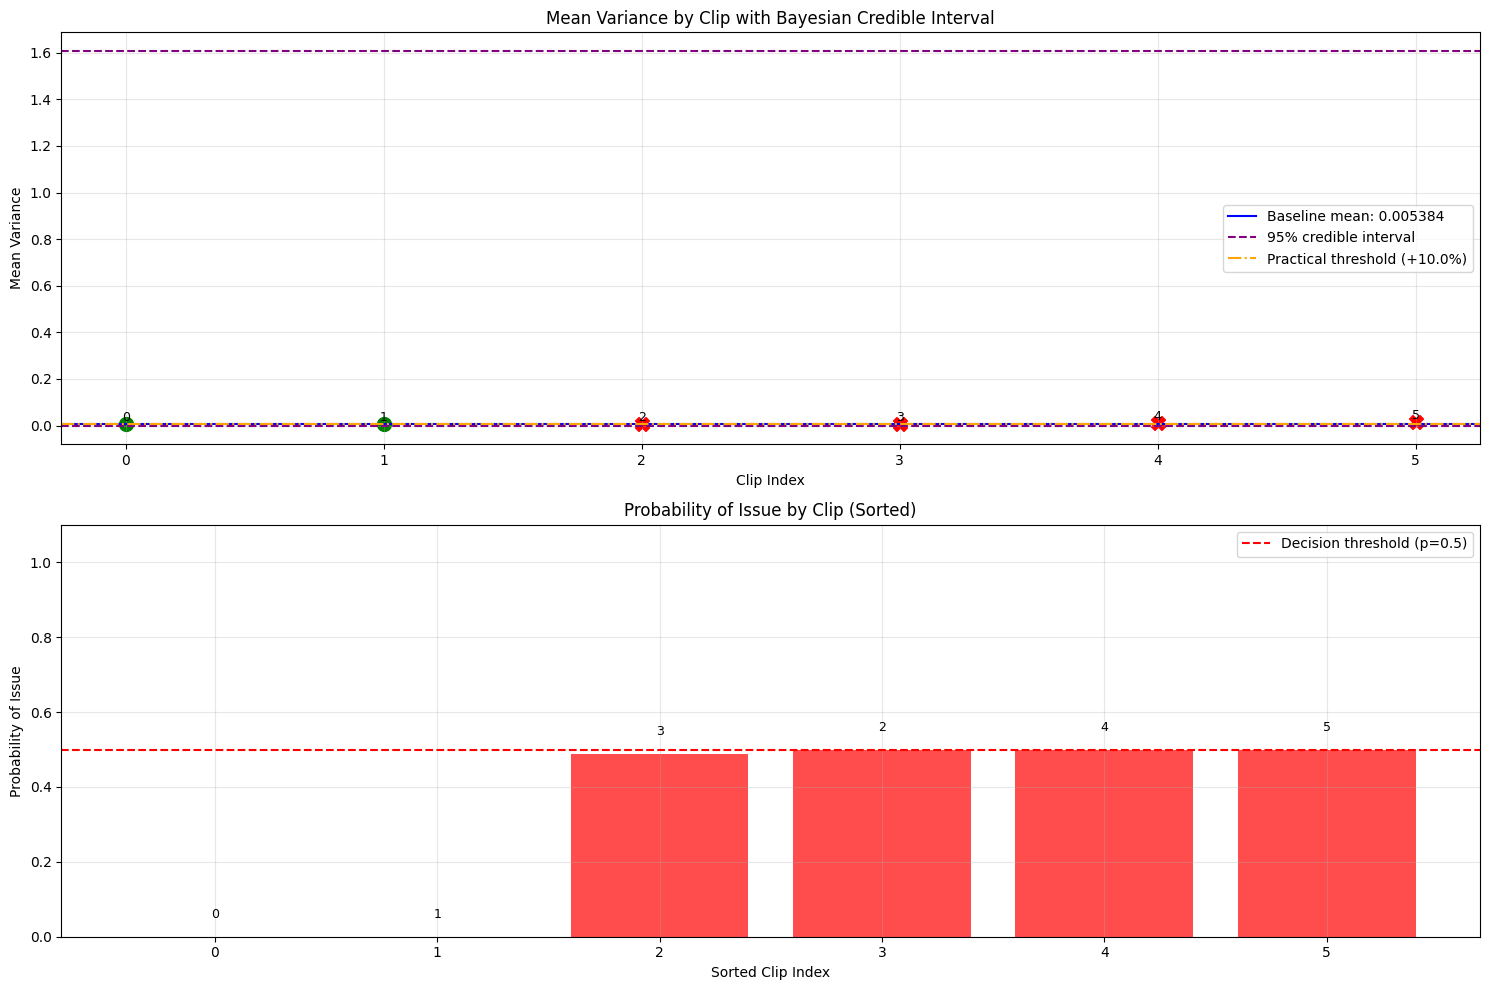

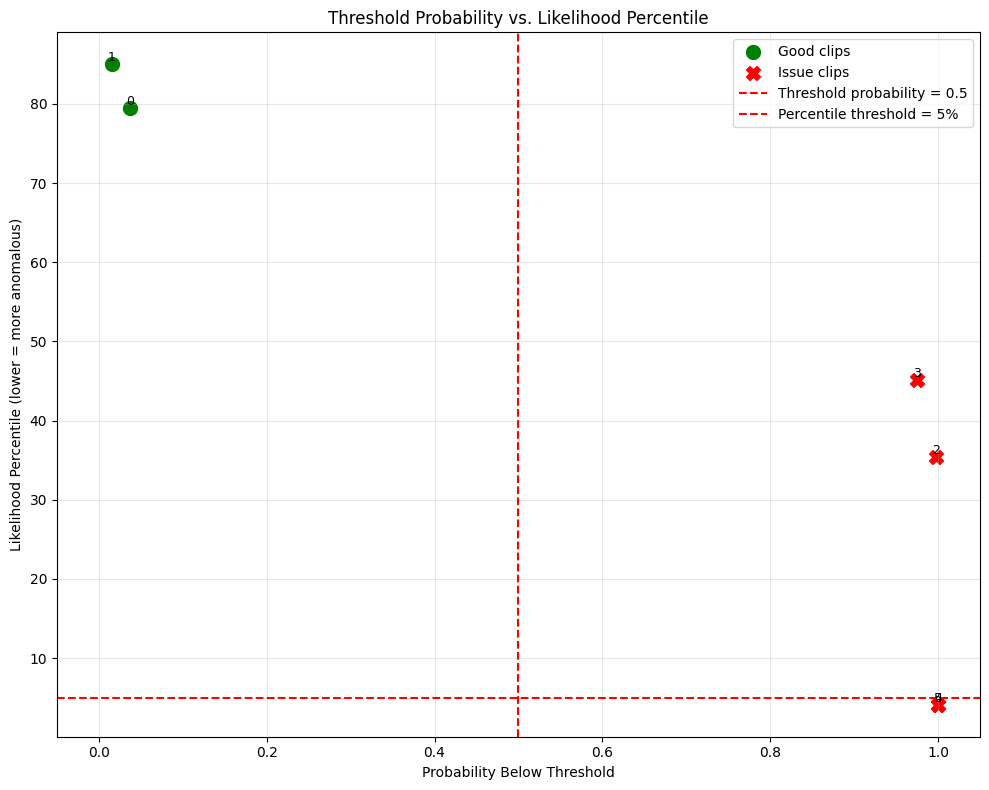


Comparison of detection approaches:
Test clip 0 (true label=0):
  Hybrid approach: Correct (p=0.000)
  Buffer approach: Correct (p=0.037)
  Interval approach: Correct (outside=False)
Test clip 1 (true label=0):
  Hybrid approach: Correct (p=0.000)
  Buffer approach: Correct (p=0.015)
  Interval approach: Correct (outside=False)
Test clip 2 (true label=1):
  Hybrid approach: Wrong (p=0.499)
  Buffer approach: Correct (p=0.998)
  Interval approach: Wrong (outside=False)
Test clip 3 (true label=1):
  Hybrid approach: Wrong (p=0.487)
  Buffer approach: Correct (p=0.975)
  Interval approach: Wrong (outside=False)
Test clip 4 (true label=1):
  Hybrid approach: Wrong (p=0.500)
  Buffer approach: Correct (p=1.000)
  Interval approach: Wrong (outside=False)
Test clip 5 (true label=1):
  Hybrid approach: Wrong (p=0.500)
  Buffer approach: Correct (p=1.000)
  Interval approach: Wrong (outside=False)

Accuracy by approach:
  Hybrid approach: 0.3333
  Buffer approach: 1.0000
  Interval approach: 0

In [71]:
import os
import numpy as np
import pymc as pm

# Load the saved data
def load_frame_variances(filepath):
    """Load frame variances from pickle file"""
    import pickle
    with open(filepath, 'rb') as f:
        return pickle.load(f)

# Load the data
data = load_frame_variances("saved_data/frame_variances_20250430_145054.pkl")

# Extract components
frame_variances = data['frame_variances']
clip_paths = data['clip_paths']
labels = data['labels']

# Find good clip indices
good_indices = [i for i, label in enumerate(labels) if label == 0]
bad_indices = [i for i, label in enumerate(labels) if label == 1]

# Use first 4 good clips as baseline
baseline_indices = good_indices[:4]
baseline_clips = [frame_variances[i] for i in baseline_indices]
baseline_paths = [clip_paths[i] for i in baseline_indices]

print(f"Using {len(baseline_clips)} clips as baseline:")
for i, path in zip(baseline_indices, baseline_paths):
    print(f"  {i}: {os.path.basename(path) if isinstance(path, str) else path}")

# Process MC dropout data by averaging each frame across MC runs
def process_mc_clip(clip):
    """Average each frame's variance across all MC runs"""
    # Get dimensions
    n_runs = len(clip)
    min_frames = min(len(run) for run in clip)
    
    # Average each frame
    avg_variances = []
    for frame_idx in range(min_frames):
        frame_variances = [clip[run_idx][frame_idx] for run_idx in range(n_runs)]
        avg_variances.append(np.mean(frame_variances))
    
    return np.array(avg_variances)

# Process baseline clips
processed_baseline_clips = [process_mc_clip(clip) for clip in baseline_clips]

# Initialize and set up hybrid monitor
# Use a smaller number of MCMC samples for testing
monitor = BayesianYOLOMonitorNBA(
    min_deviation_threshold=0.1,  # Using your threshold value
    buffer_prior_alpha=999,  # Centered around 0.9
    buffer_prior_beta=1,
    credible_interval=0.95,
    mcmc_samples=10000  # Smaller sample size for faster testing
)

# Establish baseline
print("Establishing baseline with Bayesian model...")
baseline_info = monitor.establish_baseline(processed_baseline_clips, visualize=True)
print("Baseline parameters:")
for key, value in baseline_info.items():
    print(f"  {key}: {value}")

# Then assess the model fit
fit_assessment = monitor.assess_model_fit()
print(fit_assessment)

# Check all clips by first processing them
print("\nTesting all clips:")
for i, clip in enumerate(frame_variances):
    # Process clip
    processed_clip = process_mc_clip(clip)
    
    # Check performance
    result = monitor.check_performance(processed_clip)
    
    # Is this clip in the baseline?
    in_baseline = i in baseline_indices
    
    # Get expected label (0=good, 1=bad)
    expected = labels[i]
    
    # Format result
    if in_baseline:
        status = "BASELINE"
    elif result['has_issue'] == (expected == 1):
        status = "CORRECT"
    else:
        status = "ERROR"
    
    print(f"Clip {i} ({os.path.basename(clip_paths[i]) if isinstance(clip_paths[i], str) else clip_paths[i]}): " + 
          f"{'Issue detected' if result['has_issue'] else 'OK'} - {status}")
    print(f"  Probability of issue: {result['p_has_issue']:.3f}")
    print(f"  Below threshold probability: {result['p_below_threshold']:.3f}")
    print(f"  Outside credible interval: {result['outside_credible_interval']}")

# Process test clips for evaluation
test_clips = []
test_labels = []
for i in range(len(frame_variances)):
    if i not in baseline_indices:
        processed_clip = process_mc_clip(frame_variances[i])
        test_clips.append(processed_clip)
        test_labels.append(labels[i])

# Evaluate performance
test_results = monitor.run_test(test_clips, test_labels)

print("\nPerformance metrics:")
for metric, value in test_results['metrics'].items():
    if isinstance(value, (int, float)):
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value}")

# Visualize results if desired
monitor.visualize_results(test_clips, test_labels)

# Print out comparison between hybrid and individual approaches
print("\nComparison of detection approaches:")
correct_hybrid = 0
correct_threshold = 0
correct_interval = 0
total = len(test_clips)

for i, (clip, label) in enumerate(zip(test_clips, test_labels)):
    result = monitor.check_performance(clip)
    
    hybrid_correct = (result['has_issue'] == bool(label))
    threshold_correct = ((result['p_below_threshold'] > 0.5) == bool(label))
    interval_correct = (result['outside_credible_interval'] == bool(label))
    
    if hybrid_correct:
        correct_hybrid += 1
    if threshold_correct:
        correct_threshold += 1
    if interval_correct:
        correct_interval += 1
    
    print(f"Test clip {i} (true label={label}):")
    print(f"  Hybrid approach: {'Correct' if hybrid_correct else 'Wrong'} (p={result['p_has_issue']:.3f})")
    print(f"  Buffer approach: {'Correct' if threshold_correct else 'Wrong'} (p={result['p_below_threshold']:.3f})")
    print(f"  Interval approach: {'Correct' if interval_correct else 'Wrong'} (outside={result['outside_credible_interval']})")

print("\nAccuracy by approach:")
print(f"  Hybrid approach: {correct_hybrid/total:.4f}")
print(f"  Buffer approach: {correct_threshold/total:.4f}")
print(f"  Interval approach: {correct_interval/total:.4f}")

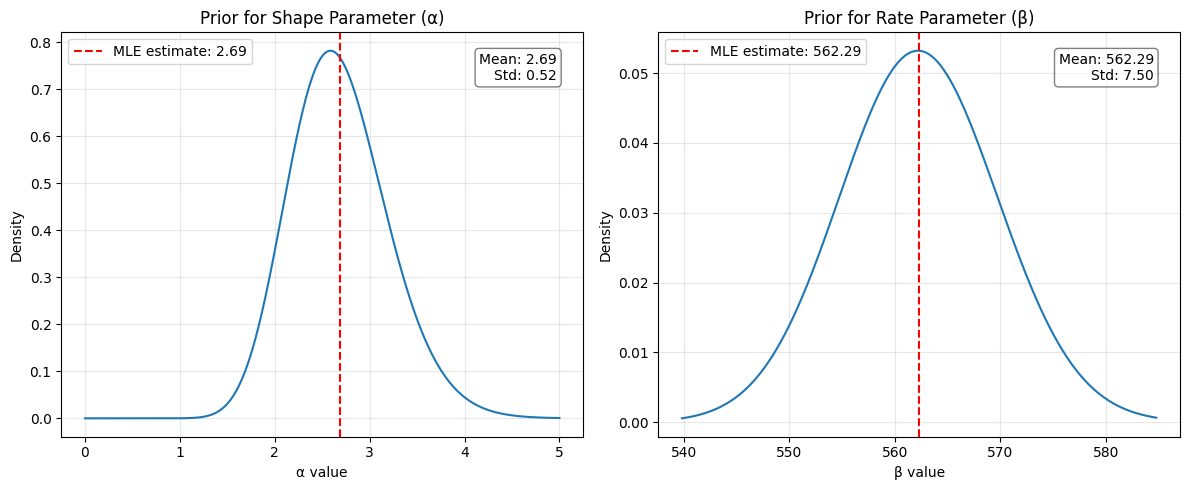

Shape parameter (α) prior: Gamma(26.86, 10.00)
Rate parameter (β) prior: Gamma(5622.93, 10.00)
α prior mean: 2.69, std: 0.52
β prior mean: 562.29, std: 7.50


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# Given values from scipy's MLE fit
shape_prior_mean = 2.686475880420536  # Alpha from scipy fit
rate_prior_mean = 562.2927370137634   # Beta from scipy fit

# Calculate parameters for the priors as in your code
alpha_prior_alpha = shape_prior_mean * 10  # = 26.86
alpha_prior_beta = 10

beta_prior_alpha = rate_prior_mean * 10  # = 5622.93
beta_prior_beta = 10

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ---- Plot for alpha prior ----
# Generate x values
x_alpha = np.linspace(0, 5, 1000)  # Range for alpha parameter

# Calculate PDF
alpha_prior_pdf = gamma.pdf(x_alpha, alpha_prior_alpha, scale=1/alpha_prior_beta)

# Plot
axes[0].plot(x_alpha, alpha_prior_pdf)
axes[0].axvline(x=shape_prior_mean, color='r', linestyle='--', 
               label=f'MLE estimate: {shape_prior_mean:.2f}')
axes[0].set_title('Prior for Shape Parameter (α)')
axes[0].set_xlabel('α value')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ---- Plot for beta prior ----
# The beta prior will be extremely concentrated due to large prior_alpha
# Determine appropriate range around the mean
beta_mean = beta_prior_alpha / beta_prior_beta
beta_std = np.sqrt(beta_prior_alpha) / beta_prior_beta
x_beta = np.linspace(beta_mean - 3*beta_std, beta_mean + 3*beta_std, 1000)

# Calculate PDF
beta_prior_pdf = gamma.pdf(x_beta, beta_prior_alpha, scale=1/beta_prior_beta)

# Plot
axes[1].plot(x_beta, beta_prior_pdf)
axes[1].axvline(x=rate_prior_mean, color='r', linestyle='--',
               label=f'MLE estimate: {rate_prior_mean:.2f}')
axes[1].set_title('Prior for Rate Parameter (β)')
axes[1].set_xlabel('β value')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Add some stats as text
alpha_std = np.sqrt(alpha_prior_alpha) / alpha_prior_beta
beta_std = np.sqrt(beta_prior_alpha) / beta_prior_beta

alpha_text = f"Mean: {alpha_prior_alpha/alpha_prior_beta:.2f}\nStd: {alpha_std:.2f}"
beta_text = f"Mean: {beta_mean:.2f}\nStd: {beta_std:.2f}"

axes[0].text(0.95, 0.95, alpha_text, transform=axes[0].transAxes, 
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

axes[1].text(0.95, 0.95, beta_text, transform=axes[1].transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

# Also print some key values
print(f"Shape parameter (α) prior: Gamma({alpha_prior_alpha:.2f}, {alpha_prior_beta:.2f})")
print(f"Rate parameter (β) prior: Gamma({beta_prior_alpha:.2f}, {beta_prior_beta:.2f})")
print(f"α prior mean: {alpha_prior_alpha/alpha_prior_beta:.2f}, std: {alpha_std:.2f}")
print(f"β prior mean: {beta_mean:.2f}, std: {beta_std:.2f}")

# WE try weird stuff

In [65]:
import numpy as np
from scipy.stats import gamma
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import pymc as pm
import warnings
warnings.filterwarnings('ignore')

class BayesianYOLOMonitorMix:
    def __init__(self, min_deviation_threshold=0.2,
                 buffer_prior_alpha=9, buffer_prior_beta=1,
                 credible_interval=0.95, mcmc_samples=1000):
        """
        Initialize Bayesian YOLO Performance Monitor without block averaging
        
        Parameters:
        - min_deviation_threshold: Minimum relative deviation to be considered significant
        - buffer_prior_alpha, buffer_prior_beta: Prior for buffer factor
          (default gives a distribution centered around 0.9)
        - credible_interval: Credible interval for anomaly detection (e.g., 0.95 for 95%)
        - mcmc_samples: Number of posterior samples to generate
        """
        # Parameters for practical significance
        self.min_deviation_threshold = min_deviation_threshold
        
        # Parameters for buffer factor
        self.buffer_prior_alpha = buffer_prior_alpha
        self.buffer_prior_beta = buffer_prior_beta
        
        # Parameters for posterior predictive distribution
        self.credible_interval = credible_interval
        self.mcmc_samples = mcmc_samples
        
        # Initialize storage for model and results
        self.model = None
        self.trace = None
        self.baseline_clips_raw = []
        self.baseline_mean_variance = None
        
        # Posterior samples
        self.alpha_posterior = None
        self.beta_posterior = None
        self.min_log_prob_posterior = None
        self.threshold_posterior = None
        self.baseline_credible_interval = None
    
    def establish_baseline_mixture(self, baseline_clips, n_components=2, visualize=False):
        """
        Establish baseline using a mixture of gamma distributions
        
        Parameters:
        - baseline_clips: List of frame variance arrays from good clips
        - n_components: Number of gamma components in the mixture
        - visualize: Whether to visualize the baseline distributions
        
        Returns:
        - baseline_info: Dictionary with baseline statistics
        """
        # Store raw clips for reference
        self.baseline_clips_raw = baseline_clips
        
        # Combine all frame variances
        all_frame_variances = []
        for clip in baseline_clips:
            all_frame_variances.extend(clip)
        
        # Calculate baseline mean variance (for practical significance)
        self.baseline_mean_variance = np.mean(all_frame_variances)
        
        # Fit Bayesian mixture of gamma models using PyMC
        with pm.Model() as self.model:
            # Mixture weights
            weights = pm.Dirichlet('weights', a=np.ones(n_components))
            
            # Parameters for each component
            alphas = []
            betas = []
            
            # Get initial guess from scipy fit
            scipy_params = gamma.fit(all_frame_variances)
            shape_init = scipy_params[0]  # Shape from scipy fit
            rate_init = 1/scipy_params[2]  # Rate from scipy fit
            
            # Create parameters for each component with different priors
            for i in range(n_components):
                # First component tries to capture the main peak
                if i == 0:
                    # Prior for shape > 1 (to create a peak away from zero)
                    alpha = pm.Gamma(f'alpha_{i}', alpha=20.0, beta=5.0)  # Prior mean around 4.0
                    # Prior for rate based on MLE fit
                    beta = pm.Gamma(f'beta_{i}', alpha=rate_init*10, beta=10)
                else:
                    # Other components try to capture the tail
                    alpha = pm.Gamma(f'alpha_{i}', alpha=1.0, beta=5.0)  # Prior mean around 0.2
                    beta = pm.Gamma(f'beta_{i}', alpha=rate_init/2*10, beta=10)  # Lower rate for longer tail
                
                alphas.append(alpha)
                betas.append(beta)
            
            # Create mixture components - use only alpha parameter with scale=1/beta
            components = []
            for i in range(n_components):
                # Create the component with the correct parameterization
                component = pm.Gamma.dist(alpha=alphas[i], beta=betas[i])
                components.append(component)
            
            # Create the mixture distribution
            mixture = pm.Mixture('mixture', w=weights, comp_dists=components, observed=all_frame_variances)
            
            # Calculate clip-level log probabilities
            clip_log_probs = []
            for j, clip in enumerate(baseline_clips):
                # For each clip, calculate log probability under the mixture
                clip_log_prob_parts = []
                
                for i in range(n_components):
                    # Calculate component log probability with correct parameterization
                    component_log_prob = pm.logp(pm.Gamma.dist(alpha=alphas[i], beta=betas[i]), clip)
                    clip_log_prob_parts.append(component_log_prob)
                
                # Calculate mixture log probability
                stacked_log_probs = []
                for i in range(n_components):
                    part = clip_log_prob_parts[i] + pm.math.log(weights[i])
                    stacked_log_probs.append(part)
                
                mixture_log_prob = pm.math.logsumexp(pm.math.stack(stacked_log_probs), axis=0)
                
                # Average log probability for this clip
                avg_log_prob = pm.Deterministic(f'avg_log_prob_{j}', 
                                            pm.math.sum(mixture_log_prob) / len(clip))
                clip_log_probs.append(avg_log_prob)
            
            # Minimum baseline log prob
            min_log_prob = pm.Deterministic('min_log_prob', 
                                        pm.math.min(pm.math.stack(clip_log_probs)))
            
            # Sample from the posterior
            self.trace = pm.sample(self.mcmc_samples, tune=1000, 
                                return_inferencedata=True, target_accept=0.95)
            
            # After sampling, print available variables in trace
            print("Available variables in trace:")
            for var_name in self.trace.posterior.data_vars:
                print(f" - {var_name}")

        # Now extract using correct names
            
        # Extract posterior samples
        # The Dirichlet parameters are stored differently than expected
        # Get weights from the trace correctly
        self.weights_posterior = {}
        for i in range(n_components):
            # Try to access with the correct variable name
            try:
                self.weights_posterior[i] = self.trace.posterior['weights'].sel(weights_dim_0=i).values.flatten()
            except:
                # Fallback method
                print(f"Warning: Could not extract weights correctly. Using equal weights.")
                self.weights_posterior[i] = np.ones(len(self.trace.posterior.draw)) / n_components

        self.alphas_posterior = {i: self.trace.posterior[f'alpha_{i}'].values.flatten() 
                                for i in range(n_components)}
        self.betas_posterior = {i: self.trace.posterior[f'beta_{i}'].values.flatten() 
                            for i in range(n_components)}
        self.min_log_prob_posterior = self.trace.posterior.min_log_prob.values.flatten()
        
        # Calculate buffer-adjusted threshold
        buffer_samples = np.random.beta(self.buffer_prior_alpha, self.buffer_prior_beta, 
                                    len(self.min_log_prob_posterior))
        self.threshold_posterior = self.min_log_prob_posterior * buffer_samples
        
        # Calculate predictive samples for credible interval
        predictive_samples = []
        n_samples = 5000
        
        for i in range(n_samples):
            # Select random posterior sample
            idx = np.random.randint(0, len(self.min_log_prob_posterior))
            
            # Select component according to weights
            weights = [self.weights_posterior[j][idx] for j in range(n_components)]
            component = np.random.choice(range(n_components), p=weights)
            
            # Generate from selected component
            alpha = self.alphas_posterior[component][idx]
            beta = self.betas_posterior[component][idx]
            sample = np.random.gamma(alpha, 1/beta)
            
            predictive_samples.append(sample)
        
        # Calculate credible interval
        lower_bound = np.percentile(predictive_samples, (1 - self.credible_interval) * 100 / 2)
        upper_bound = np.percentile(predictive_samples, 100 - (1 - self.credible_interval) * 100 / 2)
        self.baseline_credible_interval = (lower_bound, upper_bound)
        
        if visualize:
            self.visualize_baseline_mixture(n_components)
        
        # Return information about the mixture model
        return {
            'weights': {i: np.mean(self.weights_posterior[i]) for i in range(n_components)},
            'alphas': {i: np.mean(self.alphas_posterior[i]) for i in range(n_components)},
            'betas': {i: np.mean(self.betas_posterior[i]) for i in range(n_components)},
            'baseline_mean_variance': self.baseline_mean_variance,
            'min_log_prob_mean': np.mean(self.min_log_prob_posterior),
            'threshold_mean': np.mean(self.threshold_posterior),
            'threshold_95ci': np.percentile(self.threshold_posterior, [2.5, 97.5]),
            'baseline_credible_interval': self.baseline_credible_interval
        }
    
    def check_performance_mixture(self, clip_variances, n_components=2):
        """
        Check clip performance using hybrid Bayesian approach with mixture model
        
        Parameters:
        - clip_variances: Frame confidence variances from current clip
        - n_components: Number of gamma components in the mixture
        
        Returns:
        - result: Detection result with detailed metrics
        """
        from scipy.special import logsumexp
        
        if self.model is None or self.trace is None:
            return {'status': 'error', 'message': 'Baseline not established'}
        
        # Calculate mean variance for practical significance
        mean_variance = np.mean(clip_variances)
        
        # Calculate relative deviation for practical significance
        relative_deviation = (mean_variance - self.baseline_mean_variance) / self.baseline_mean_variance
        
        # Practical significance check
        is_practically_significant = relative_deviation > self.min_deviation_threshold
        
        # Direction check - positive deviation means worse performance
        is_worse_direction = relative_deviation > 0
        
        # ===== Approach 1: Buffer-Factor Threshold =====
        # Calculate log likelihood for new clip using posterior samples
        n_samples = len(self.min_log_prob_posterior)
        clip_log_likelihoods = np.zeros(n_samples)
        
        for i in range(n_samples):
            # For each posterior sample
            mixture_log_probs = np.zeros(n_components)
            
            for j in range(n_components):
                # Get component parameters
                weight = self.weights_posterior[j][i]
                alpha = self.alphas_posterior[j][i]
                beta = self.betas_posterior[j][i]
                
                # Calculate component log probability
                component_log_probs = gamma.logpdf(clip_variances, alpha, scale=1/beta)
                mixture_log_probs[j] = np.log(weight) + np.mean(component_log_probs)
            
            # Use log-sum-exp for numerical stability
            clip_log_likelihoods[i] = logsumexp(mixture_log_probs)
        
        # Calculate probability that clip log likelihood is below threshold
        p_below_threshold = np.mean(clip_log_likelihoods < self.threshold_posterior)
        
        # ===== Approach 2: Posterior Predictive =====
        # Check if mean variance falls outside credible interval (upper bound only)
        outside_credible_interval = mean_variance > self.baseline_credible_interval[1]
        
        # Generate reference samples from posterior predictive for percentile
        n_reference = 1000
        reference_log_likelihoods = []
        
        for _ in range(n_reference):
            # Select random posterior sample
            idx = np.random.randint(0, len(self.min_log_prob_posterior))
            
            # Select component according to weights
            weights = [self.weights_posterior[j][idx] for j in range(n_components)]
            component = np.random.choice(range(n_components), p=weights)
            
            # Get parameters for this component
            alpha = self.alphas_posterior[component][idx]
            beta = self.betas_posterior[component][idx]
            
            # Generate sample from this gamma
            sample = np.random.gamma(alpha, 1/beta, size=len(clip_variances))
            
            # Calculate log likelihood of this sample using the mixture
            sample_log_probs = np.zeros(n_components)
            for j in range(n_components):
                w = self.weights_posterior[j][idx]
                a = self.alphas_posterior[j][idx]
                b = self.betas_posterior[j][idx]
                sample_log_probs[j] = np.log(w) + np.mean(gamma.logpdf(sample, a, scale=1/b))
            
            # Log-sum-exp for numerical stability
            sample_log_likelihood = logsumexp(sample_log_probs)
            reference_log_likelihoods.append(sample_log_likelihood)
        
        # Calculate percentile
        mean_log_likelihood = np.mean(clip_log_likelihoods)
        likelihood_percentile = np.mean(np.array(reference_log_likelihoods) <= mean_log_likelihood) * 100
        
        # ===== Combined Decision =====
        # Hybrid approach - use both statistical indicators with practical significance
        p_has_issue = 0.0
        if is_practically_significant and is_worse_direction:
            # Combine both statistical indicators (average them)
            p_has_issue = (p_below_threshold + int(outside_credible_interval)) / 2
        
        # Final dictionary output with all metrics
        return {
            'p_has_issue': p_has_issue,
            'has_issue': p_has_issue > 0.5,  # Binary decision based on probability
            'p_below_threshold': p_below_threshold,
            'outside_credible_interval': outside_credible_interval,
            'is_practically_significant': is_practically_significant,
            'is_worse_direction': is_worse_direction,
            'mean_variance': mean_variance,
            'baseline_mean_variance': self.baseline_mean_variance,
            'relative_deviation': relative_deviation * 100,  # Present as percentage
            'min_deviation_threshold': self.min_deviation_threshold * 100,  # Present as percentage
            'mean_log_likelihood': mean_log_likelihood,
            'log_likelihood_95ci': np.percentile(clip_log_likelihoods, [2.5, 97.5]),
            'threshold_mean': np.mean(self.threshold_posterior),
            'threshold_95ci': np.percentile(self.threshold_posterior, [2.5, 97.5]),
            'baseline_credible_interval': self.baseline_credible_interval,
            'likelihood_percentile': likelihood_percentile
        }
    
    def update_baseline(self, new_clip_variances):
        """
        Update baseline distribution with new data using Bayesian update
        
        Parameters:
        - new_clip_variances: Frame variances from new clip to add to baseline
        
        Returns:
        - updated_params: Dictionary with updated parameters
        """
        # Add new clip to raw baseline clips
        self.baseline_clips_raw.append(new_clip_variances)
        
        # Re-establish baseline with all clips
        return self.establish_baseline(self.baseline_clips_raw, visualize=False)
    
    def visualize_baseline_mixture(self, n_components=2):
        """
        Visualize baseline distributions with mixture model
        """
        # Create a figure
        plt.figure(figsize=(12, 8))
        
        # Combine all variances for histogram
        all_variances = []
        for clip in self.baseline_clips_raw:
            all_variances.extend(clip)
        
        # Plot histogram
        plt.hist(all_variances, bins=50, alpha=0.7, density=True, color='green', 
                label='Baseline frame variances')
        
        # Plot the posterior expected gamma mixture distribution
        x = np.linspace(min(all_variances), max(all_variances), 1000)
        
        # Plot multiple posterior samples
        n_curves = 30
        indices = np.random.choice(len(self.min_log_prob_posterior), n_curves)
        
        for i in indices:
            # For each posterior sample
            pdf_total = np.zeros_like(x)
            
            for j in range(n_components):
                # Get component parameters
                weight = self.weights_posterior[j][i]
                alpha = self.alphas_posterior[j][i]
                beta = self.betas_posterior[j][i]
                
                # Calculate component pdf - NOTE THE CHANGE HERE
                pdf = weight * gamma.pdf(x, alpha, scale=1/beta)
                pdf_total += pdf
                
                # Plot component (first few samples only)
                if i < 3:
                    plt.plot(x, pdf, '--', lw=0.5, alpha=0.3)
            
            # Plot total mixture
            plt.plot(x, pdf_total, 'r-', lw=0.1, alpha=0.1)
        
        # Plot the posterior mean mixture distribution
        pdf_total = np.zeros_like(x)
        
        for j in range(n_components):
            # Get mean component parameters
            weight = np.mean(self.weights_posterior[j])
            alpha = np.mean(self.alphas_posterior[j])
            beta = np.mean(self.betas_posterior[j])
            
            # Calculate component pdf
            pdf = weight * gamma.pdf(x, alpha, scale=1/beta)
            pdf_total += pdf
            
            # Plot component
            plt.plot(x, pdf, '--', lw=1, alpha=0.5,
                    label=f'Component {j+1}: w={weight:.2f}, α={alpha:.2f}, β={beta:.2f}')
        
        # Plot total mixture
        plt.plot(x, pdf_total, 'r-', lw=2, 
                label='Posterior mean mixture')
        
        # Mark the credible interval
        plt.axvline(x=self.baseline_credible_interval[0], color='purple', linestyle='--')
        plt.axvline(x=self.baseline_credible_interval[1], color='purple', linestyle='--',
                label=f'{self.credible_interval:.0%} credible interval')
        
        # Mark the mean variance
        plt.axvline(x=self.baseline_mean_variance, color='blue', linestyle='-', 
                label=f'Mean variance: {self.baseline_mean_variance:.6f}')
        
        plt.title('Baseline Frame Variance Distribution with Mixture Model Fit')
        plt.xlabel('Variance')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    def visualize_results(self, test_clips, labels):
        """
        Visualize test results
        
        Parameters:
        - test_clips: List of clips to visualize
        - labels: Binary labels (1=issue, 0=good)
        """
        # Calculate metrics for each clip
        results = []
        for clip in test_clips:
            results.append(self.check_performance_mixture(clip))
        
        # Extract metrics
        mean_variances = [r['mean_variance'] for r in results]
        percentiles = [r['likelihood_percentile'] for r in results]
        p_below_thresholds = [r['p_below_threshold'] for r in results]
        deviations = [r['relative_deviation'] for r in results]
        outside_intervals = [r['outside_credible_interval'] for r in results]
        p_has_issues = [r['p_has_issue'] for r in results]
        
        # Create plot
        plt.figure(figsize=(15, 10))
        
        # 1. Mean variances with credible interval
        plt.subplot(2, 1, 1)
        
        # Define colors and markers
        colors = ['green' if label == 0 else 'red' for label in labels]
        shapes = ['o' if label == 0 else 'X' for label in labels]
        
        # Plot each clip
        for i, (mv, c, m) in enumerate(zip(mean_variances, colors, shapes)):
            plt.scatter(i, mv, color=c, marker=m, s=100)
        
        # Add clip labels
        for i, mv in enumerate(mean_variances):
            plt.text(i, mv, f"{i}", fontsize=9, ha='center', va='bottom')
        
        # Plot baseline mean and credible interval
        plt.axhline(y=self.baseline_mean_variance, color='blue', linestyle='-',
                label=f'Baseline mean: {self.baseline_mean_variance:.6f}')
        plt.axhline(y=self.baseline_credible_interval[0], color='purple', linestyle='--')
        plt.axhline(y=self.baseline_credible_interval[1], color='purple', linestyle='--',
                label=f'{self.credible_interval:.0%} credible interval')
        plt.axhline(y=self.baseline_mean_variance * (1 + self.min_deviation_threshold),
                color='orange', linestyle='-.',
                label=f'Practical threshold (+{self.min_deviation_threshold*100:.1f}%)')
        
        plt.title('Mean Variance by Clip with Bayesian Credible Interval')
        plt.xlabel('Clip Index')
        plt.ylabel('Mean Variance')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Probability of issue
        plt.subplot(2, 1, 2)
        
        # Sort by probability for better visualization
        sorted_indices = np.argsort(p_has_issues)
        sorted_probs = [p_has_issues[i] for i in sorted_indices]
        sorted_colors = [colors[i] for i in sorted_indices]
        sorted_shapes = [shapes[i] for i in sorted_indices]
        
        # Plot bars
        for i, (p, c) in enumerate(zip(sorted_probs, sorted_colors)):
            plt.bar(i, p, color=c, alpha=0.7)
        
        # Add clip indices as labels
        for i, idx in enumerate(sorted_indices):
            plt.text(i, sorted_probs[i] + 0.05, f"{idx}", fontsize=9, ha='center')
        
        # Add threshold line
        plt.axhline(y=0.5, color='red', linestyle='--',
                label='Decision threshold (p=0.5)')
        
        plt.title('Probability of Issue by Clip (Sorted)')
        plt.xlabel('Sorted Clip Index')
        plt.ylabel('Probability of Issue')
        plt.ylim(0, 1.1)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Create a metrics scatter plot
        plt.figure(figsize=(10, 8))
        
        # Plot percentile vs. probability
        plt.scatter([pt for pt, l in zip(p_below_thresholds, labels) if l == 0],
                [pct for pct, l in zip(percentiles, labels) if l == 0],
                color='green', marker='o', s=100, label='Good clips')
        plt.scatter([pt for pt, l in zip(p_below_thresholds, labels) if l == 1],
                [pct for pct, l in zip(percentiles, labels) if l == 1],
                color='red', marker='X', s=100, label='Issue clips')
        
        # Add clip indices
        for i, (pt, pct) in enumerate(zip(p_below_thresholds, percentiles)):
            plt.text(pt, pct, f"{i}", fontsize=9, ha='center', va='bottom')
        
        # Add threshold lines
        plt.axvline(x=0.5, color='red', linestyle='--',
                label='Threshold probability = 0.5')
        plt.axhline(y=5, color='red', linestyle='--',
                label='Percentile threshold = 5%')
        
        plt.title('Threshold Probability vs. Likelihood Percentile')
        plt.xlabel('Probability Below Threshold')
        plt.ylabel('Likelihood Percentile (lower = more anomalous)')
        plt.xlim(-0.05, 1.05)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def assess_model_fit_mixture(self, n_components=2):
        """
        Assess model fit for mixture model using various metrics
        
        Parameters:
        - n_components: Number of gamma components in the mixture
        
        Returns:
        - fit_assessment: Dictionary with fit metrics
        """
        if self.model is None or self.trace is None:
            return {'status': 'error', 'message': 'Baseline not established'}
        
        # Get all frame variances
        all_frame_variances = []
        for clip in self.baseline_clips_raw:
            all_frame_variances.extend(clip)
        
        # Calculate direct fit parameters for comparison
        direct_fit_params = gamma.fit(all_frame_variances)
        direct_fit_alpha = direct_fit_params[0]
        direct_fit_beta = 1/direct_fit_params[2]  # Convert scale to rate
        
        # Calculate posterior mean parameters for each component
        alpha_means = {i: np.mean(self.alphas_posterior[i]) for i in range(n_components)}
        beta_means = {i: np.mean(self.betas_posterior[i]) for i in range(n_components)}
        
        # Get mixture weights
        weight_means = {i: np.mean(self.weights_posterior[i]) for i in range(n_components)}
        
        # Calculate theoretical moments for the mixture
        theoretical_mean = sum(weight_means[i] * alpha_means[i] / beta_means[i] for i in range(n_components))
        theoretical_var = sum(weight_means[i] * (alpha_means[i] * (alpha_means[i] + 1) / (beta_means[i]**2)) 
                            for i in range(n_components)) - theoretical_mean**2
        
        # Empirical moments
        empirical_mean = np.mean(all_frame_variances)
        empirical_var = np.var(all_frame_variances)
        
        # Calculate mean log likelihood under posterior
        n_samples = min(100, len(self.min_log_prob_posterior))  # Use subset for efficiency
        sample_indices = np.random.choice(len(self.min_log_prob_posterior), n_samples, replace=False)
        
        log_likelihoods = np.zeros(n_samples)
        for i, idx in enumerate(sample_indices):
            # Calculate mixture log likelihood
            mixture_log_lik = 0
            for j in range(n_components):
                weight = self.weights_posterior[j][idx]
                alpha = self.alphas_posterior[j][idx]
                beta = self.betas_posterior[j][idx]
                
                # For the first component, initialize the log likelihood
                if j == 0:
                    mixture_log_lik = np.log(weight) + np.sum(gamma.logpdf(all_frame_variances, alpha, scale=1/beta))
                else:
                    # Use log-sum-exp for numerical stability
                    component_log_lik = np.log(weight) + np.sum(gamma.logpdf(all_frame_variances, alpha, scale=1/beta))
                    mixture_log_lik = np.logaddexp(mixture_log_lik, component_log_lik)
            
            log_likelihoods[i] = mixture_log_lik
        
        mean_log_likelihood = np.mean(log_likelihoods)
        
        # Posterior predictive check - generate samples
        n_pred_samples = 5000
        pred_samples = []
        
        for i in range(n_pred_samples):
            # Select random posterior sample
            idx = np.random.randint(0, len(self.min_log_prob_posterior))
            
            # Select component according to weights
            weights = [self.weights_posterior[j][idx] for j in range(n_components)]
            component = np.random.choice(range(n_components), p=weights)
            
            # Generate from selected component
            alpha = self.alphas_posterior[component][idx]
            beta = self.betas_posterior[component][idx]
            sample = np.random.gamma(alpha, 1/beta)
            
            pred_samples.append(sample)
        
        # Calculate Q-Q plot correlation (PPCC)
        # Sort the data
        sorted_data = np.sort(all_frame_variances)
        sorted_pred = np.sort(pred_samples)
        
        # Resample to match lengths
        if len(sorted_pred) > len(sorted_data):
            indices = np.linspace(0, len(sorted_pred)-1, len(sorted_data)).astype(int)
            sorted_pred = sorted_pred[indices]
        elif len(sorted_data) > len(sorted_pred):
            indices = np.linspace(0, len(sorted_data)-1, len(sorted_pred)).astype(int)
            sorted_data = sorted_data[indices]
        
        # Calculate correlation
        ppcc = np.corrcoef(sorted_pred, sorted_data)[0, 1]
        
        return {
            'direct_fit': {
                'shape': direct_fit_alpha,
                'rate': direct_fit_beta
            },
            'mixture_components': {
                i: {
                    'weight': weight_means[i],
                    'shape': alpha_means[i],
                    'rate': beta_means[i]
                } for i in range(n_components)
            },
            'moments': {
                'theoretical_mean': theoretical_mean,
                'empirical_mean': empirical_mean,
                'mean_relative_error': abs(theoretical_mean - empirical_mean) / empirical_mean,
                'theoretical_var': theoretical_var,
                'empirical_var': empirical_var,
                'var_relative_error': abs(theoretical_var - empirical_var) / empirical_var
            },
            'goodness_of_fit': {
                'mean_log_likelihood': mean_log_likelihood,
                'mean_log_likelihood_per_point': mean_log_likelihood / len(all_frame_variances),
                'ppcc': ppcc
            },
            'interpretation': {
                'good_fit': (ppcc > 0.95 and 
                            abs(theoretical_mean - empirical_mean) / empirical_mean < 0.05 and
                            abs(theoretical_var - empirical_var) / empirical_var < 0.1),
                'ppcc_interpretation': 'Good fit' if ppcc > 0.95 else 'Moderate fit' if ppcc > 0.9 else 'Poor fit'
            }
        }
    
    def run_test(self, test_clips, labels):
        """
        Run test on labeled clips to evaluate monitor performance
        
        Parameters:
        - test_clips: List of clips to test
        - labels: Binary labels (1=issue, 0=good)
        
        Returns:
        - results: Test results with metrics
        """
        if self.model is None or self.trace is None:
            return {'status': 'error', 'message': 'Baseline not established'}
        
        # Test each clip
        results = []
        for clip, label in zip(test_clips, labels):
            result = self.check_performance_mixture(clip)
            result['true_label'] = label
            result['correct'] = (result['has_issue'] == bool(label))
            results.append(result)
        
        # Calculate metrics
        true_positives = sum(1 for r in results if r['has_issue'] and r['true_label'])
        false_positives = sum(1 for r in results if r['has_issue'] and not r['true_label'])
        true_negatives = sum(1 for r in results if not r['has_issue'] and not r['true_label'])
        false_negatives = sum(1 for r in results if not r['has_issue'] and r['true_label'])
        
        total = len(results)
        accuracy = (true_positives + true_negatives) / total if total > 0 else 0
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Visualize results
        self.visualize_results(test_clips, labels)
        
        return {
            'results': results,
            'metrics': {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'true_positives': true_positives,
                'false_positives': false_positives,
                'true_negatives': true_negatives,
                'false_negatives': false_negatives
            }
        }

Using 4 clips as baseline:
  0: clip_0017.mp4
  1: clip_0018.mp4
  2: clip_0019.mp4
  3: clip_0020.mp4
Establishing baseline with Bayesian model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, alpha_0, beta_0, alpha_1, beta_1]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 149 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Available variables in trace:
 - weights
 - alpha_0
 - beta_0
 - alpha_1
 - beta_1
 - avg_log_prob_0
 - avg_log_prob_1
 - avg_log_prob_2
 - avg_log_prob_3
 - min_log_prob


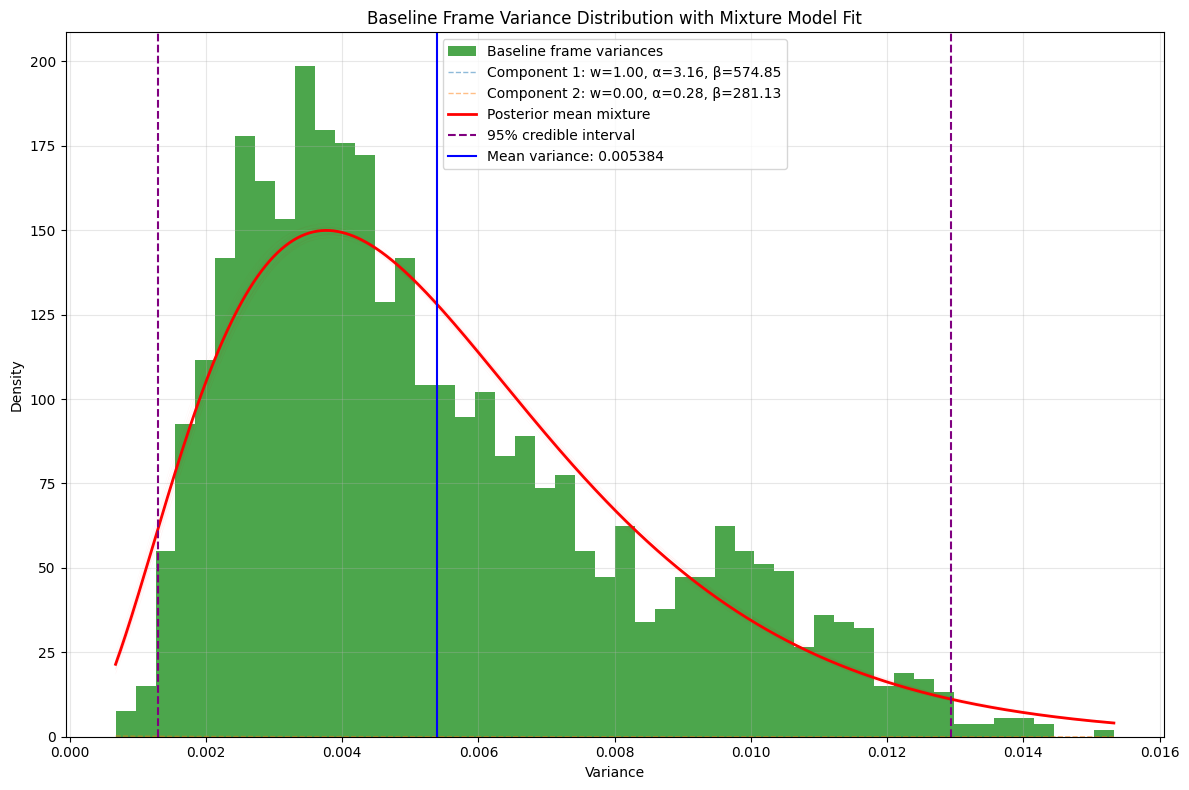

Baseline parameters:
  weights: {0: np.float64(0.9991352994108391), 1: np.float64(0.0008647005891608193)}
  alphas: {0: np.float64(3.164740303400146), 1: np.float64(0.2779631385236873)}
  betas: {0: np.float64(574.8524564943893), 1: np.float64(281.12633236849547)}
  baseline_mean_variance: 0.005383805539332935
  min_log_prob_mean: 4.495858924652161
  threshold_mean: 4.043483313766966
  threshold_95ci: [2.96966122 4.48299656]
  baseline_credible_interval: (np.float64(0.0012873948351648646), np.float64(0.012944664444207964))
{'direct_fit': {'shape': np.float64(2.686475880420536), 'rate': np.float64(562.2927370137634)}, 'mixture_components': {0: {'weight': np.float64(0.9991352994108391), 'shape': np.float64(3.164740303400146), 'rate': np.float64(574.8524564943893)}, 1: {'weight': np.float64(0.0008647005891608193), 'shape': np.float64(0.2779631385236873), 'rate': np.float64(281.12633236849547)}}, 'moments': {'theoretical_mean': np.float64(0.0055014033550767885), 'empirical_mean': np.float6

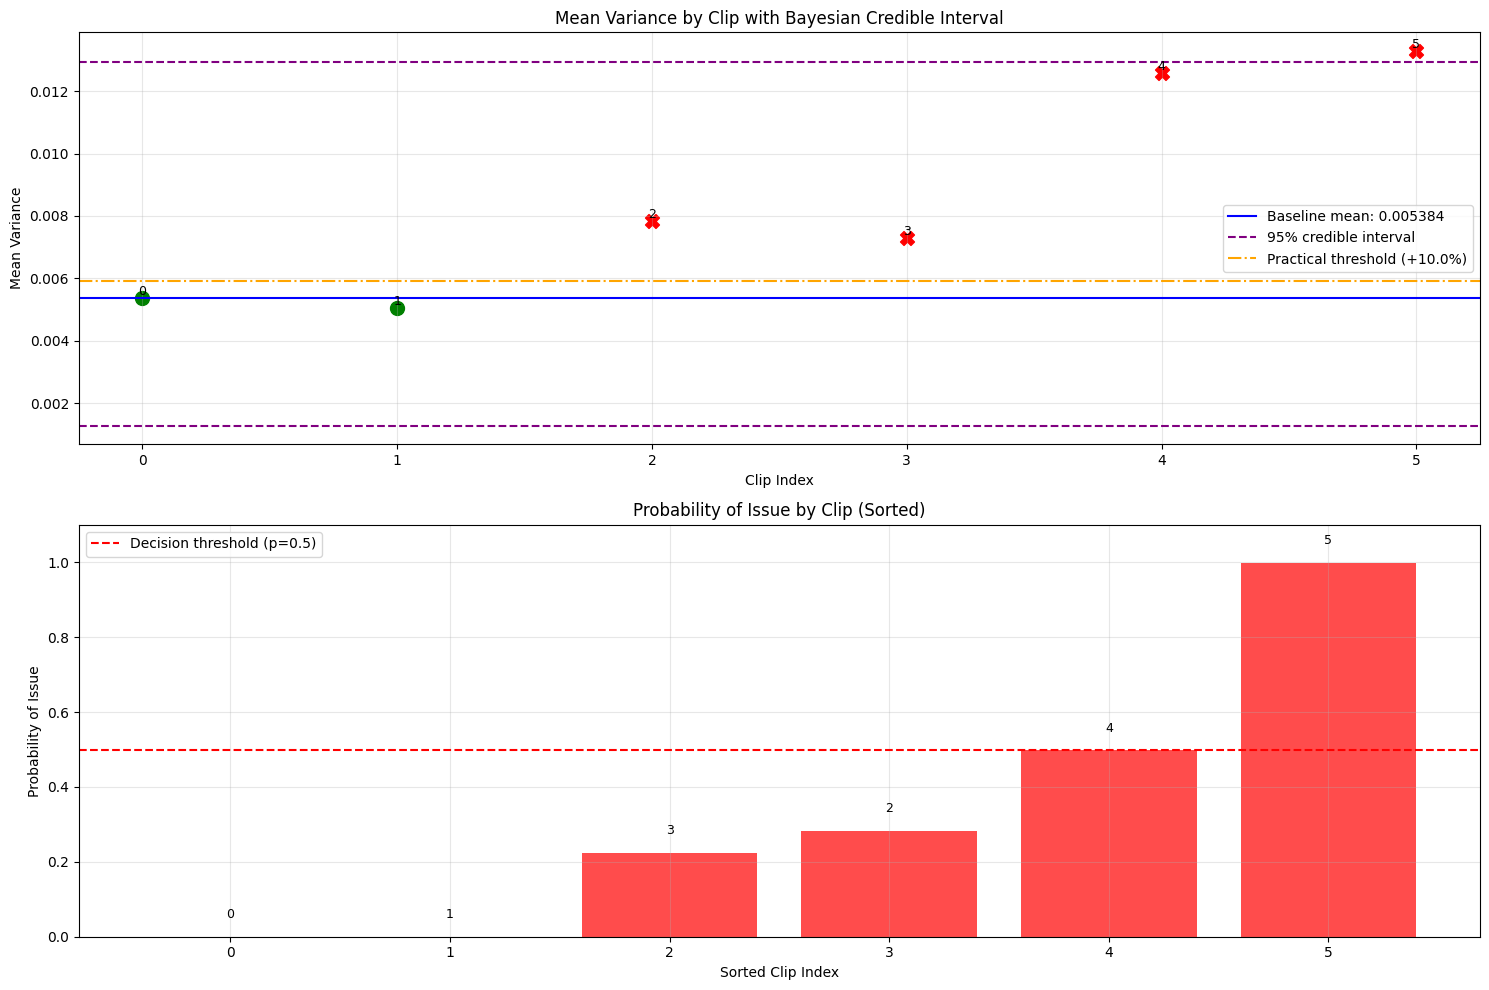

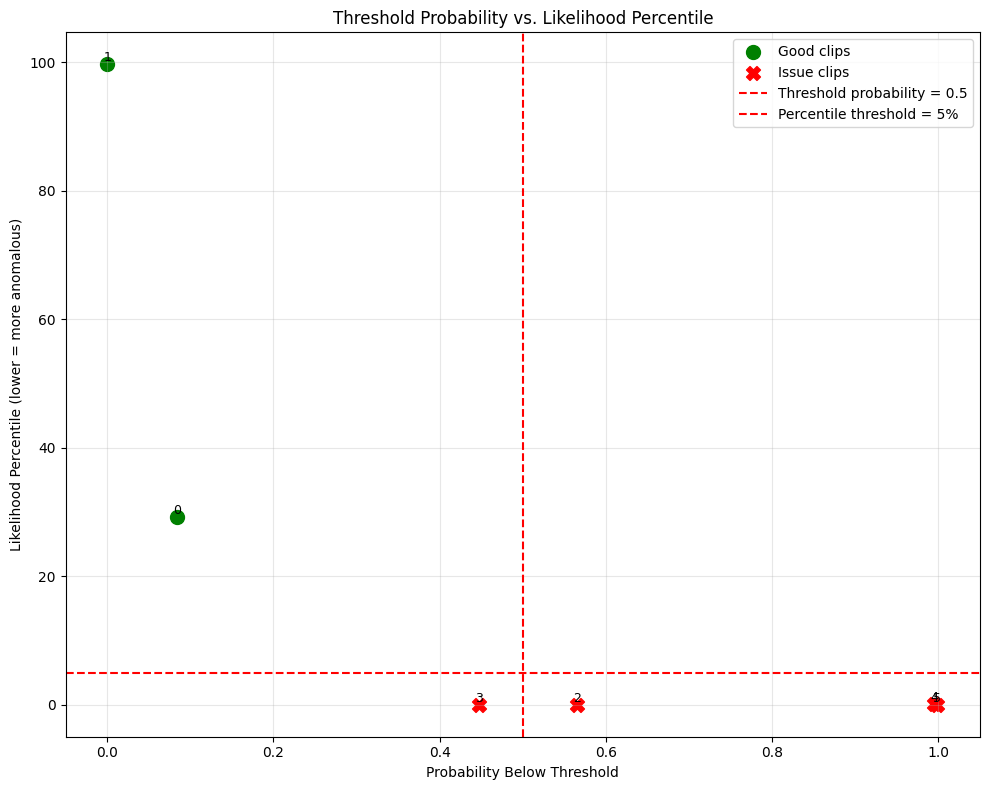


Performance metrics:
  accuracy: 0.5000
  precision: 1.0000
  recall: 0.2500
  f1: 0.4000
  true_positives: 1.0000
  false_positives: 0.0000
  true_negatives: 2.0000
  false_negatives: 3.0000


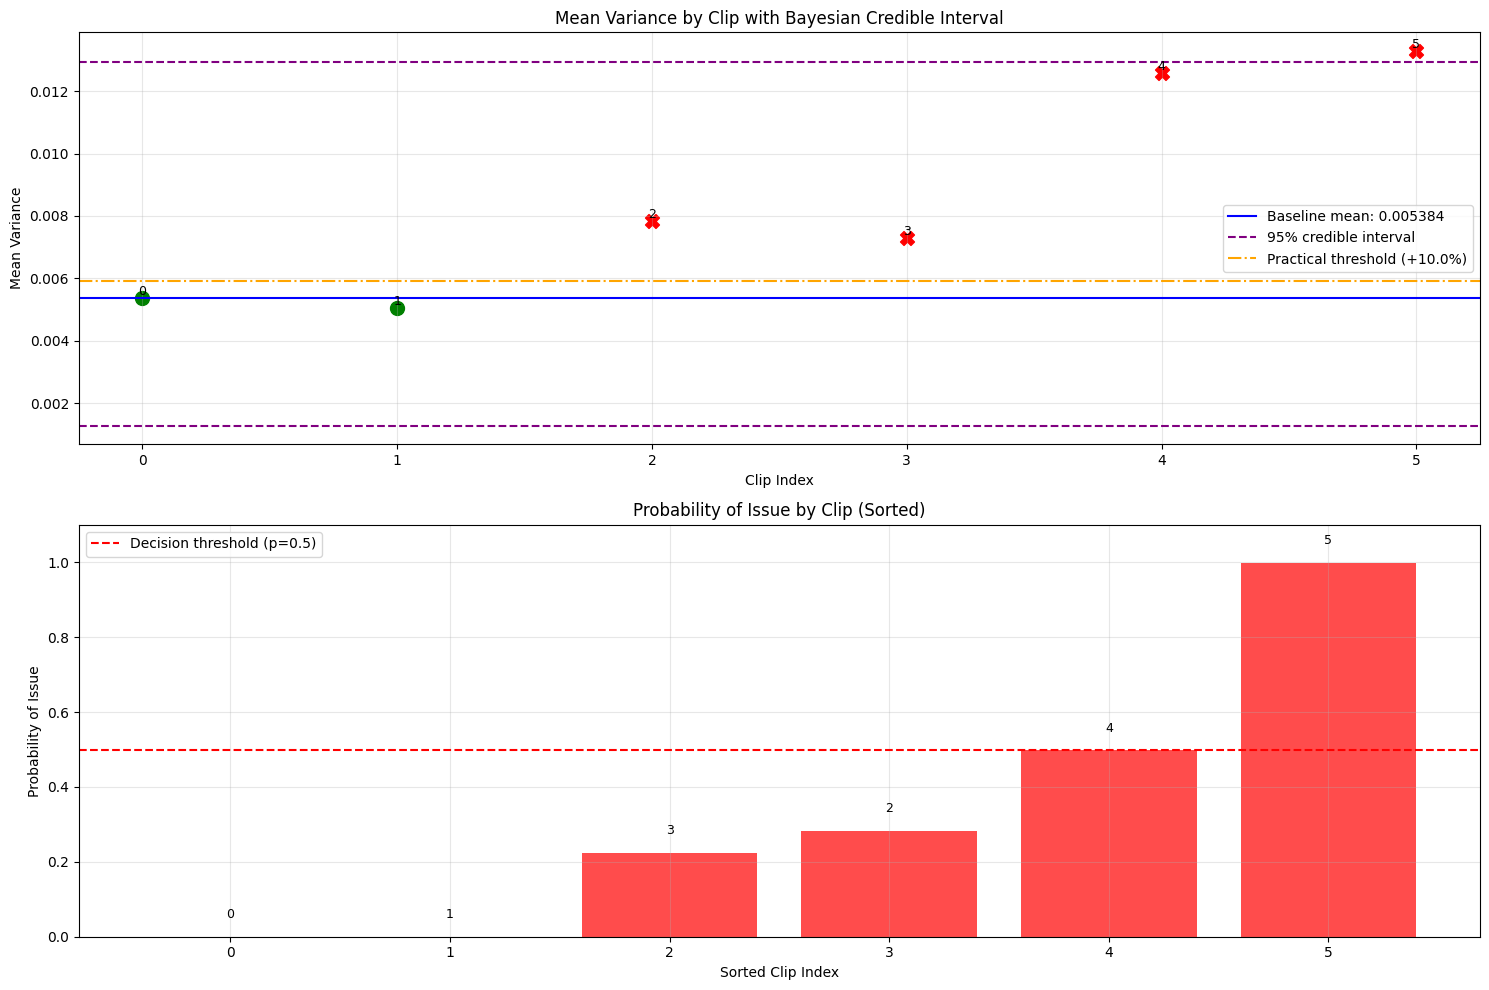

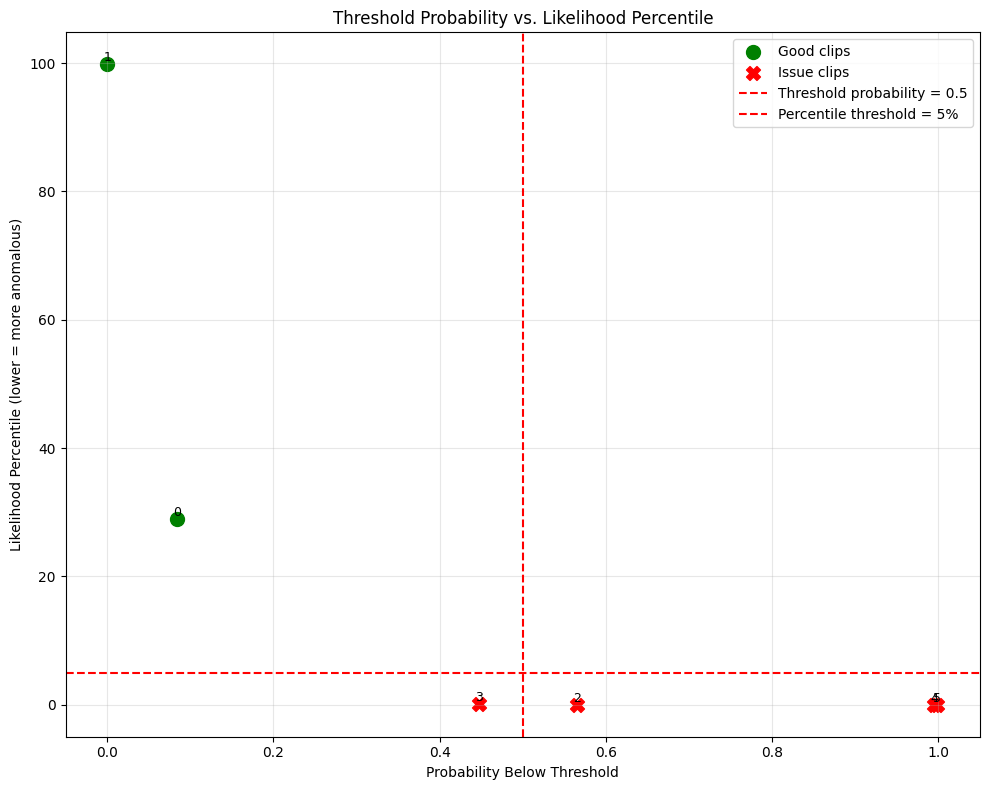


Comparison of detection approaches:
Test clip 0 (true label=0):
  Hybrid approach: Correct (p=0.000)
  Buffer approach: Correct (p=0.084)
  Interval approach: Correct (outside=False)
Test clip 1 (true label=0):
  Hybrid approach: Correct (p=0.000)
  Buffer approach: Correct (p=0.000)
  Interval approach: Correct (outside=False)
Test clip 2 (true label=1):
  Hybrid approach: Wrong (p=0.283)
  Buffer approach: Correct (p=0.566)
  Interval approach: Wrong (outside=False)
Test clip 3 (true label=1):
  Hybrid approach: Wrong (p=0.224)
  Buffer approach: Wrong (p=0.447)
  Interval approach: Wrong (outside=False)
Test clip 4 (true label=1):
  Hybrid approach: Wrong (p=0.497)
  Buffer approach: Correct (p=0.995)
  Interval approach: Wrong (outside=False)
Test clip 5 (true label=1):
  Hybrid approach: Correct (p=0.999)
  Buffer approach: Correct (p=0.998)
  Interval approach: Correct (outside=True)

Accuracy by approach:
  Hybrid approach: 0.5000
  Buffer approach: 0.8333
  Interval approach: 

In [66]:
import os
import numpy as np
# Load the saved data
def load_frame_variances(filepath):
    """Load frame variances from pickle file"""
    import pickle
    with open(filepath, 'rb') as f:
        return pickle.load(f)

# Load the data
data = load_frame_variances("saved_data/frame_variances_20250430_145054.pkl")

# Extract components
frame_variances = data['frame_variances']
clip_paths = data['clip_paths']
labels = data['labels']

# Find good clip indices
good_indices = [i for i, label in enumerate(labels) if label == 0]
bad_indices = [i for i, label in enumerate(labels) if label == 1]

# Use first 4 good clips as baseline
baseline_indices = good_indices[:4]
baseline_clips = [frame_variances[i] for i in baseline_indices]
baseline_paths = [clip_paths[i] for i in baseline_indices]

print(f"Using {len(baseline_clips)} clips as baseline:")
for i, path in zip(baseline_indices, baseline_paths):
    print(f"  {i}: {os.path.basename(path) if isinstance(path, str) else path}")

# Process MC dropout data by averaging each frame across MC runs
def process_mc_clip(clip):
    """Average each frame's variance across all MC runs"""
    # Get dimensions
    n_runs = len(clip)
    min_frames = min(len(run) for run in clip)
    
    # Average each frame
    avg_variances = []
    for frame_idx in range(min_frames):
        frame_variances = [clip[run_idx][frame_idx] for run_idx in range(n_runs)]
        avg_variances.append(np.mean(frame_variances))
    
    return np.array(avg_variances)

# Process baseline clips
processed_baseline_clips = [process_mc_clip(clip) for clip in baseline_clips]

# Initialize and set up hybrid monitor
# Use a smaller number of MCMC samples for testing
monitor = BayesianYOLOMonitorMix(
    min_deviation_threshold=0.1,  # Using your threshold value
    buffer_prior_alpha=9,  # Centered around 0.9
    buffer_prior_beta=1,
    credible_interval=0.95,
    mcmc_samples=10000  # Smaller sample size for faster testing
)

# Establish baseline
print("Establishing baseline with Bayesian model...")
baseline_info = monitor.establish_baseline_mixture(processed_baseline_clips, visualize=True)
print("Baseline parameters:")
for key, value in baseline_info.items():
    print(f"  {key}: {value}")

# Then assess the model fit
fit_assessment = monitor.assess_model_fit_mixture()
print(fit_assessment)

# Check all clips by first processing them
print("\nTesting all clips:")
for i, clip in enumerate(frame_variances):
    # Process clip
    processed_clip = process_mc_clip(clip)
    
    # Check performance
    result = monitor.check_performance_mixture(processed_clip)
    
    # Is this clip in the baseline?
    in_baseline = i in baseline_indices
    
    # Get expected label (0=good, 1=bad)
    expected = labels[i]
    
    # Format result
    if in_baseline:
        status = "BASELINE"
    elif result['has_issue'] == (expected == 1):
        status = "CORRECT"
    else:
        status = "ERROR"
    
    print(f"Clip {i} ({os.path.basename(clip_paths[i]) if isinstance(clip_paths[i], str) else clip_paths[i]}): " + 
          f"{'Issue detected' if result['has_issue'] else 'OK'} - {status}")
    print(f"  Probability of issue: {result['p_has_issue']:.3f}")
    print(f"  Below threshold probability: {result['p_below_threshold']:.3f}")
    print(f"  Outside credible interval: {result['outside_credible_interval']}")

# Process test clips for evaluation
test_clips = []
test_labels = []
for i in range(len(frame_variances)):
    if i not in baseline_indices:
        processed_clip = process_mc_clip(frame_variances[i])
        test_clips.append(processed_clip)
        test_labels.append(labels[i])

# Evaluate performance
test_results = monitor.run_test(test_clips, test_labels)

print("\nPerformance metrics:")
for metric, value in test_results['metrics'].items():
    if isinstance(value, (int, float)):
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value}")

# Visualize results if desired
monitor.visualize_results(test_clips, test_labels)

# Print out comparison between hybrid and individual approaches
print("\nComparison of detection approaches:")
correct_hybrid = 0
correct_threshold = 0
correct_interval = 0
total = len(test_clips)

for i, (clip, label) in enumerate(zip(test_clips, test_labels)):
    result = monitor.check_performance_mixture(clip)
    
    hybrid_correct = (result['has_issue'] == bool(label))
    threshold_correct = ((result['p_below_threshold'] > 0.5) == bool(label))
    interval_correct = (result['outside_credible_interval'] == bool(label))
    
    if hybrid_correct:
        correct_hybrid += 1
    if threshold_correct:
        correct_threshold += 1
    if interval_correct:
        correct_interval += 1
    
    print(f"Test clip {i} (true label={label}):")
    print(f"  Hybrid approach: {'Correct' if hybrid_correct else 'Wrong'} (p={result['p_has_issue']:.3f})")
    print(f"  Buffer approach: {'Correct' if threshold_correct else 'Wrong'} (p={result['p_below_threshold']:.3f})")
    print(f"  Interval approach: {'Correct' if interval_correct else 'Wrong'} (outside={result['outside_credible_interval']})")

print("\nAccuracy by approach:")
print(f"  Hybrid approach: {correct_hybrid/total:.4f}")
print(f"  Buffer approach: {correct_threshold/total:.4f}")
print(f"  Interval approach: {correct_interval/total:.4f}")